In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import r2_score
import xgboost

In [18]:
_df = pd.read_csv("../data/flow.csv", index_col=0)
df = _df.copy()
df.rename(columns={'m_B': 'Eq-B', 'm_C': 'Eq-C', 't_RT1': '$t_{res}$-1','t_RT2': '$t_{res}$-2', 'T_methyl': 'Temp-2', 'T_drawH': 'Temp-1', 'yield': "Yield", "impurity": "Impurity"}, inplace=True)
df["Enantioselectivity"] = 100 - df["Impurity"]
df.drop("yield_trans", inplace=True, axis=1)

In [19]:
df.head()

,Eq-B,$t_{res}$-1,Temp-1,Eq-C,$t_{res}$-2,Temp-2,Yield,Impurity,Enantioselectivity
1,2.66,8.45,-39.0,3.15,121.2,-30,54.65,9.43,90.57
2,2.65,4.23,-39.0,3.15,121.2,-30,74.50,13.01,86.99
3,2.66,2.07,-39.0,3.15,121.2,-30,72.93,15.10,84.90
4,2.13,4.81,-39.0,3.15,121.2,-30,48.80,14.46,85.54
5,3.13,3.70,-39.0,3.15,121.2,-30,71.73,19.33,80.67


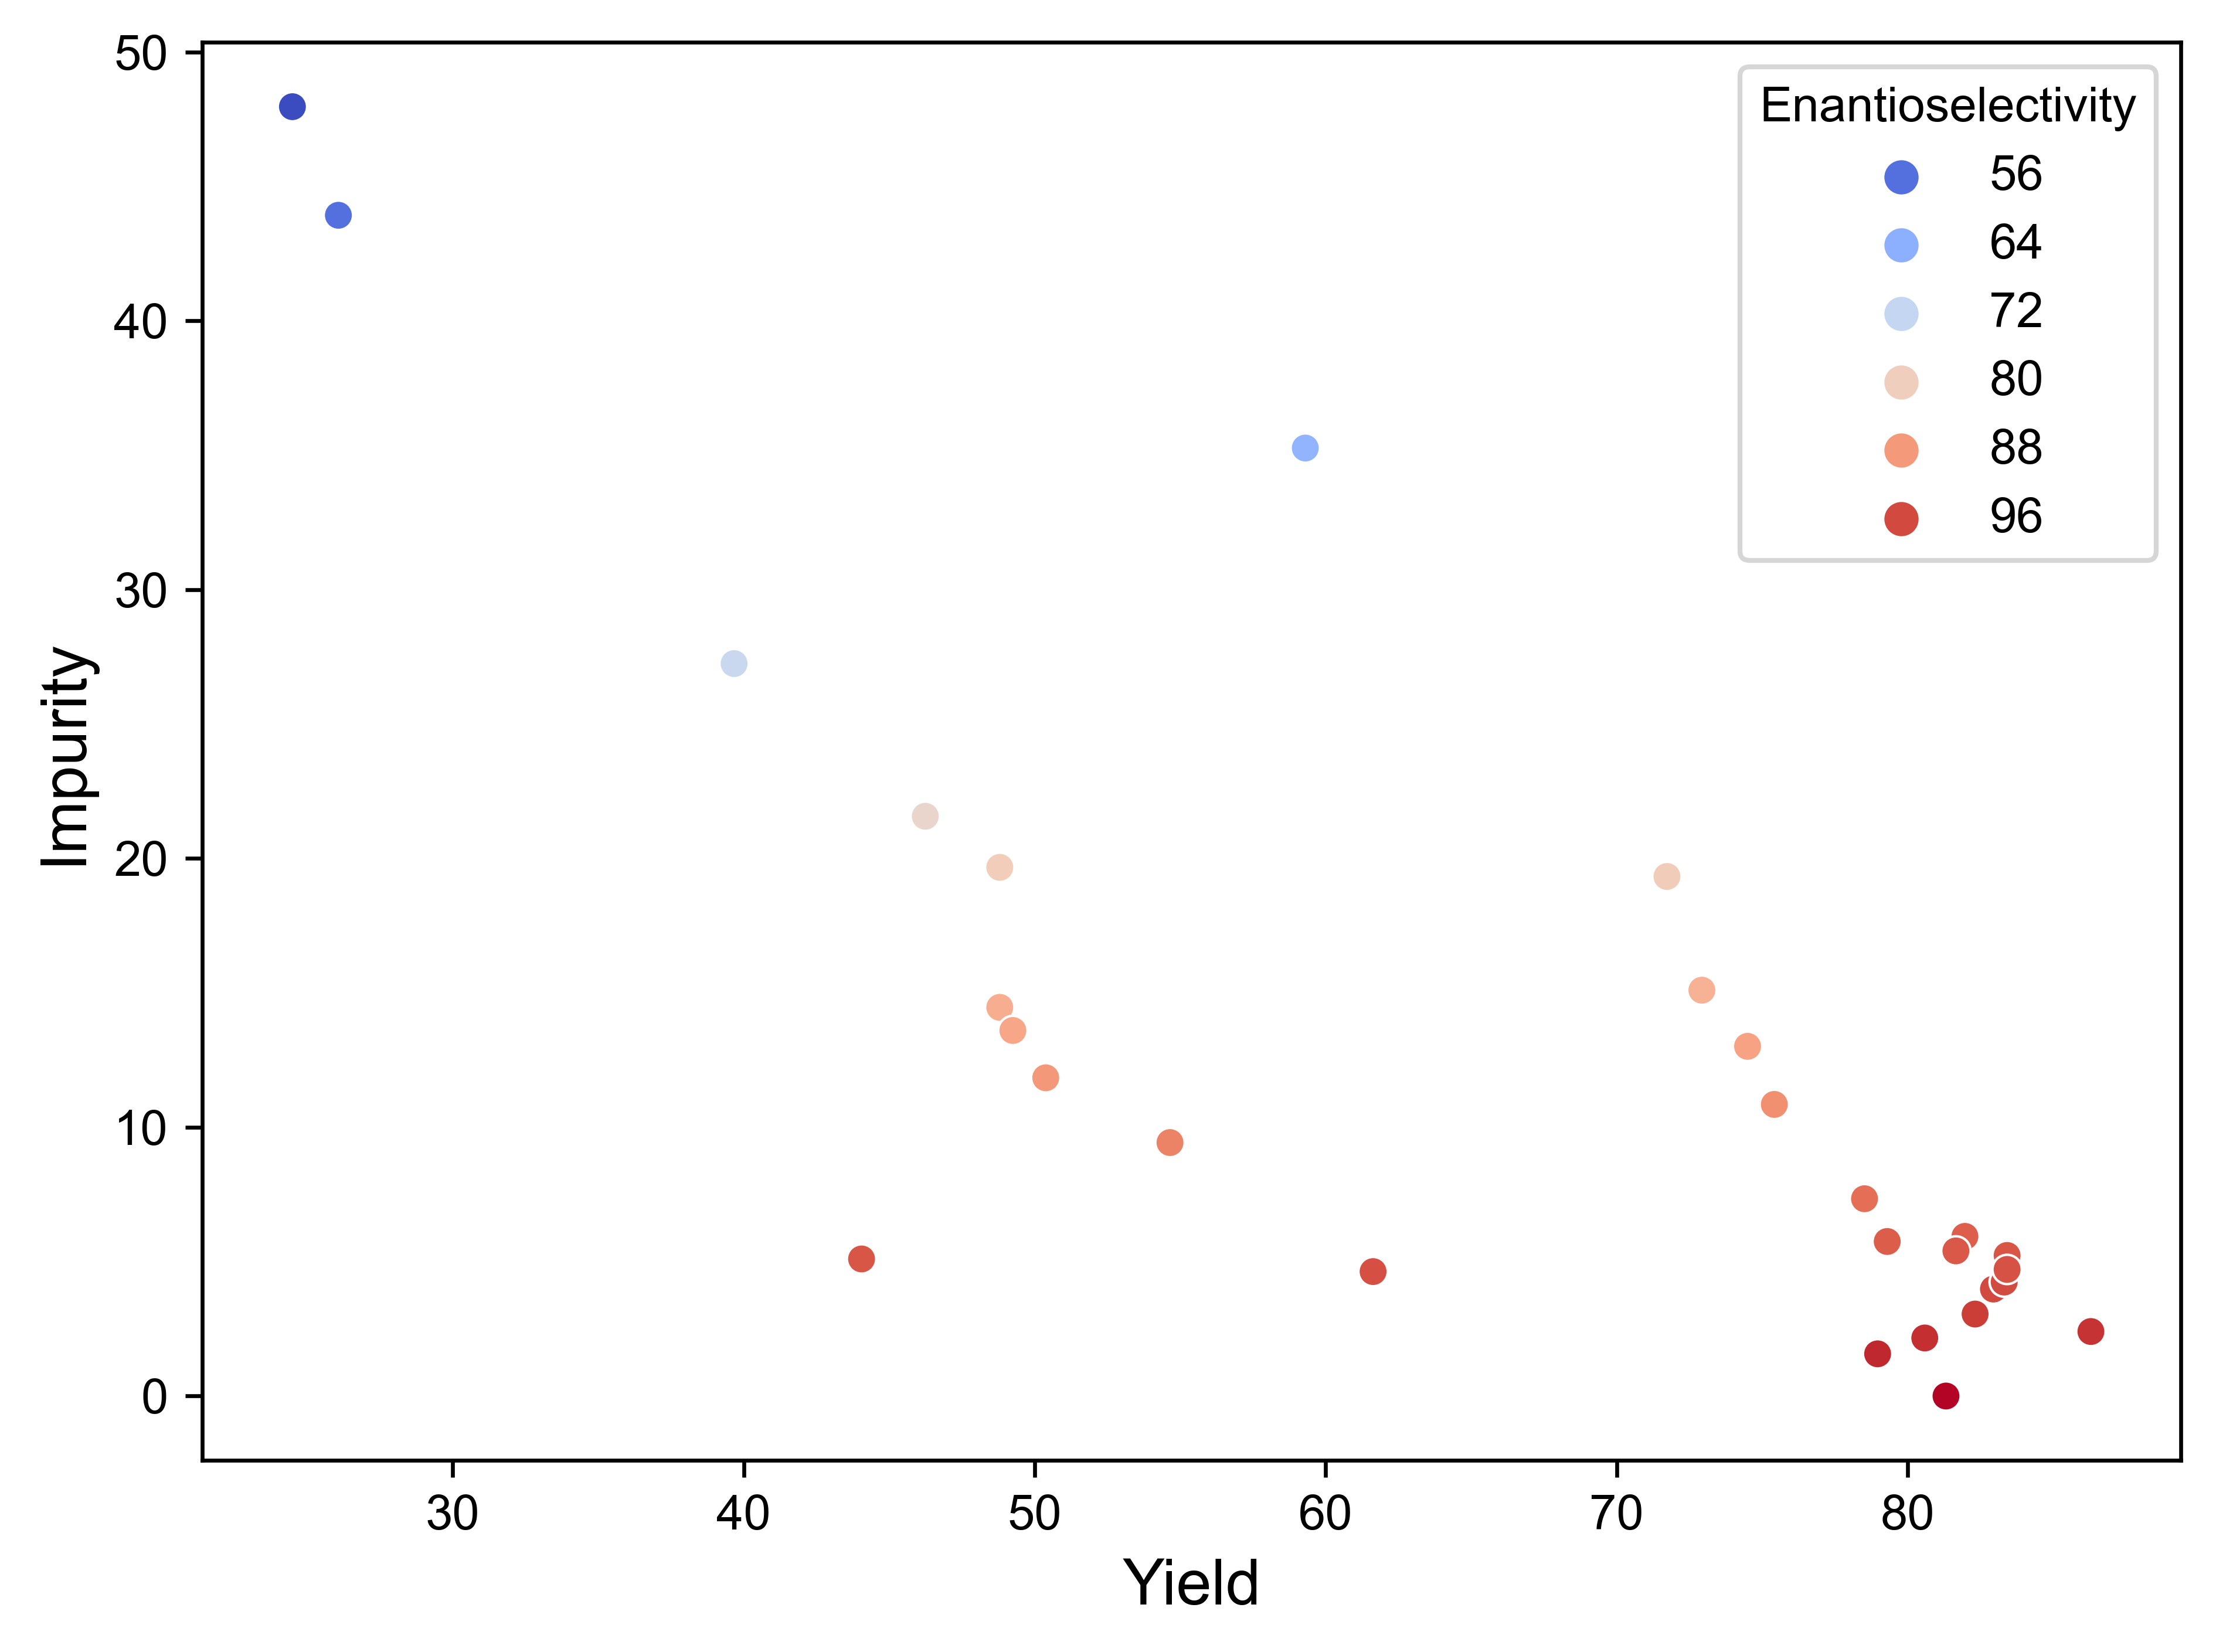

In [20]:
plt.rcParams["font.family"] = "arial"
plt.rcParams['figure.dpi'] = 600

scatter = sns.scatterplot(x=df["Yield"], y=df["Impurity"], hue=df["Enantioselectivity"], palette="coolwarm", sizes=(20, 200), edgecolor="w", linewidth=0.5)

# Set title and labels with custom font sizes
plt.xlabel('Yield', fontsize=13)
plt.ylabel('Impurity', fontsize=13)

# Fine-tuning
# scatter.legend().set_title('Selectivity Levels')
plt.tight_layout()

# Display the plot
plt.show()


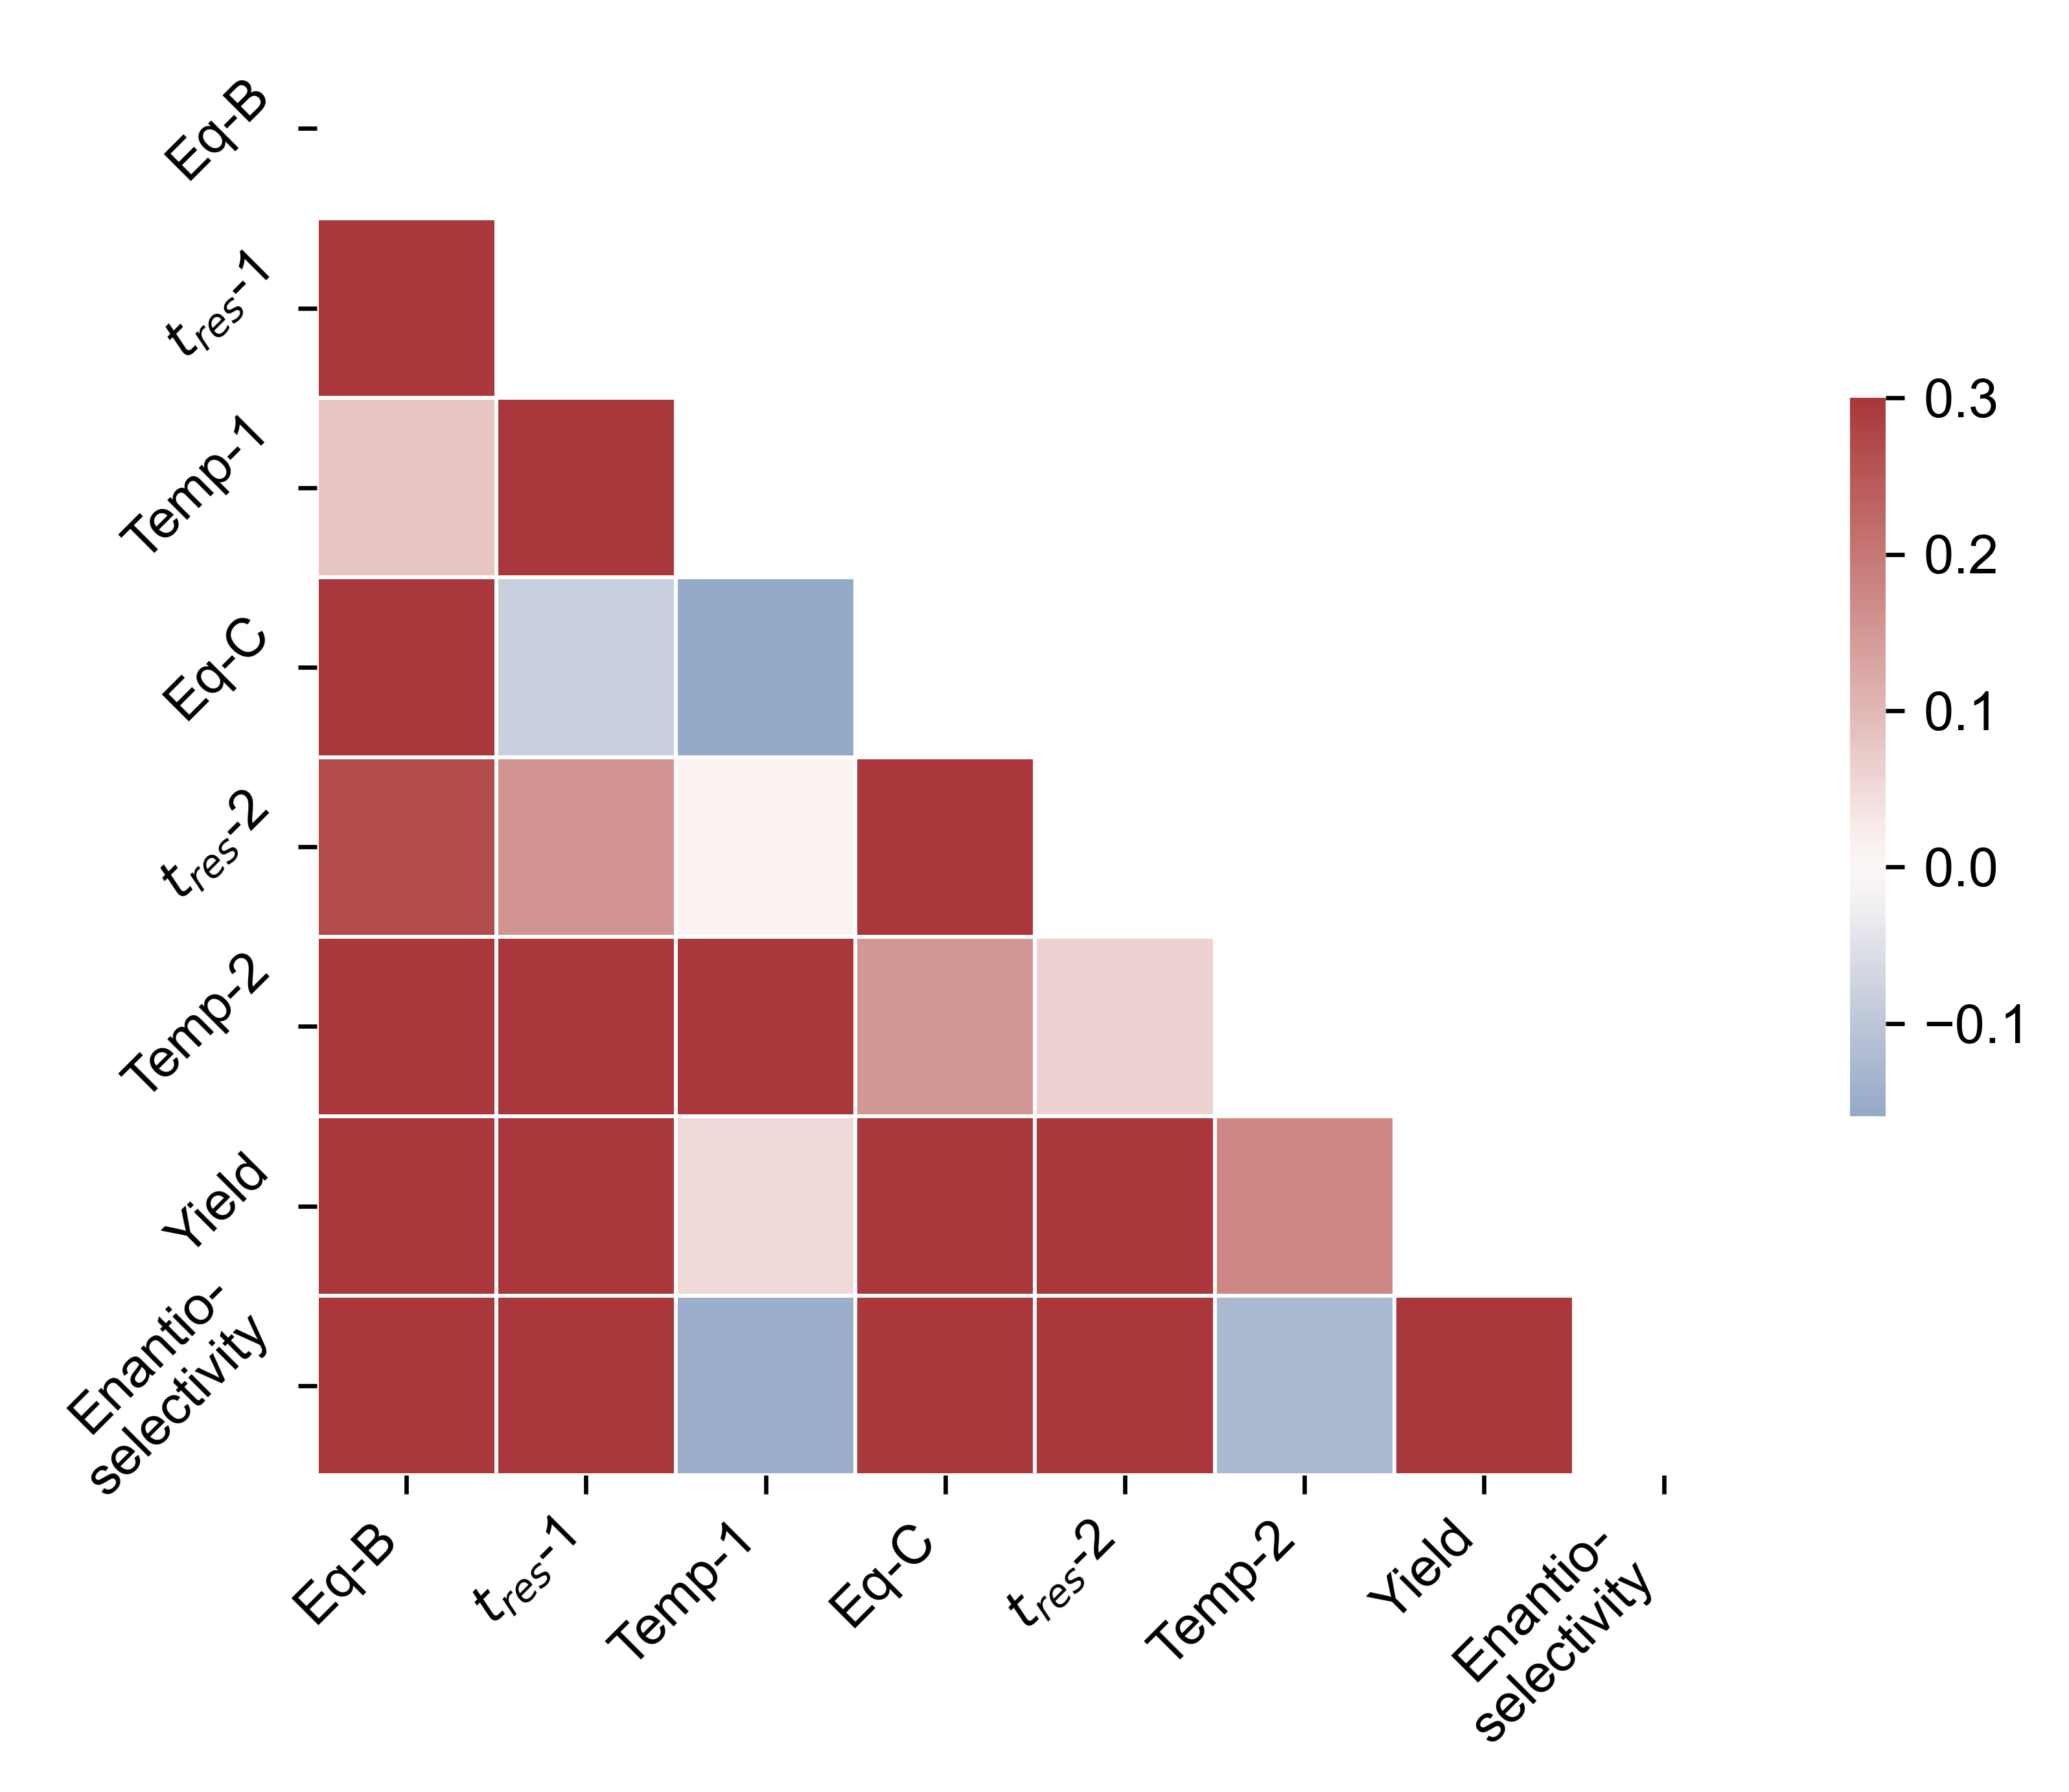

In [21]:
# 选择DataFrame中的数值列并计算相关性
df.drop("Impurity", inplace=True, axis=1)
df.rename({"Enantioselectivity": "Enantio-\nselectivity"}, inplace=True, axis=1)  # 添加换行符
correlation_data = df.select_dtypes(include=[np.number]).corr()

# 创建一个掩码，用于隐藏热图的上三角形部分
mask = np.zeros_like(correlation_data, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# 创建画布
f, ax = plt.subplots(dpi=600)

# 使用自定义的颜色图来绘制相关性热图
sns.heatmap(
    correlation_data,
    mask=mask,
    cmap="vlag",  # 使用"vlag"颜色映射
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5}
)

# 倾斜x和y轴的标签
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=45)

plt.show()  # 显示热图


## Using SHAP and XGBoost for feature contribution anylysis

In [3]:
shap.initjs()

In [23]:
df.head()

,Eq-B,$t_{res}$-1,Temp-1,Eq-C,$t_{res}$-2,Temp-2,Yield,Enantio-\nselectivity
1,2.66,8.45,-39.0,3.15,121.2,-30,54.65,90.57
2,2.65,4.23,-39.0,3.15,121.2,-30,74.50,86.99
3,2.66,2.07,-39.0,3.15,121.2,-30,72.93,84.90
4,2.13,4.81,-39.0,3.15,121.2,-30,48.80,85.54
5,3.13,3.70,-39.0,3.15,121.2,-30,71.73,80.67


In [25]:
df_yield = _df.drop(["yield_trans", "impurity"], axis=1)

X = df_yield.drop(["yield"], axis=1)
y = df_yield["yield"]

In [26]:
best_idx = df_yield.nlargest(n=3, columns="yield").index.to_list()
worst_idx = df_yield.nsmallest(n=3, columns="yield").index.to_list()

In [27]:
model = xgboost.XGBRegressor().fit(X, y)
y_pred = model.predict(X)
print(f"r2 score: {r2_score(y, y_pred)}")

explainer = shap.Explainer(model)
shap_values = explainer(X)

r2 score: 0.9999999972214878


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


86.3


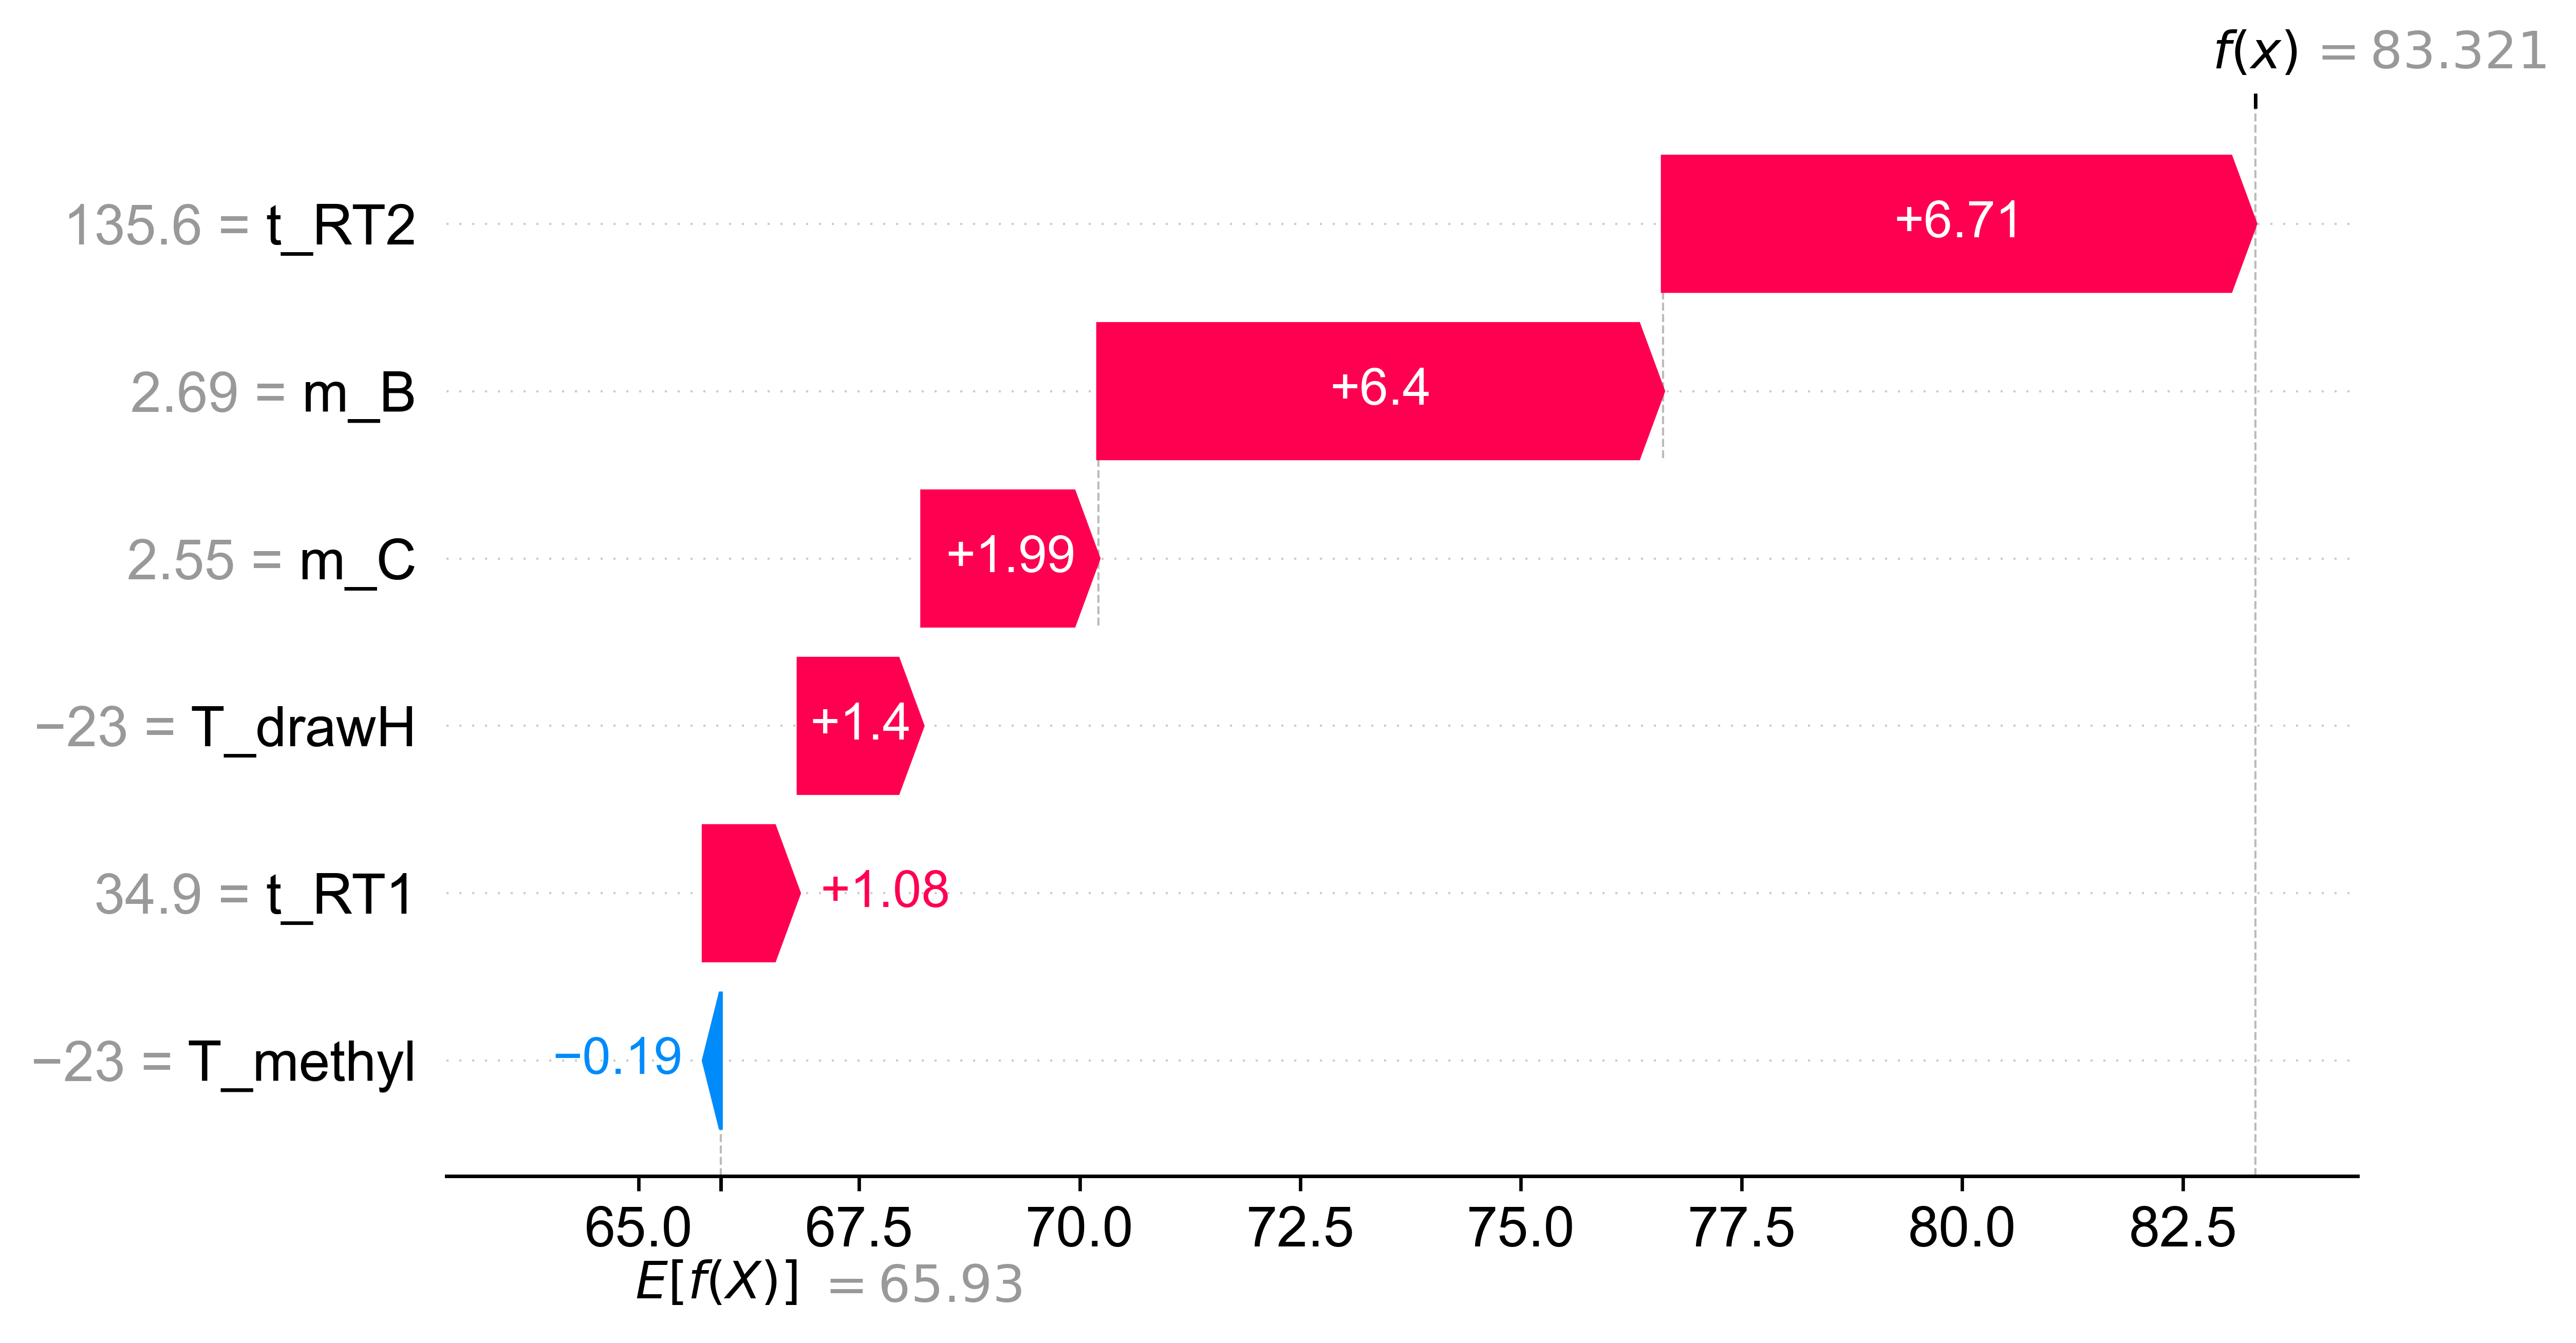

83.42


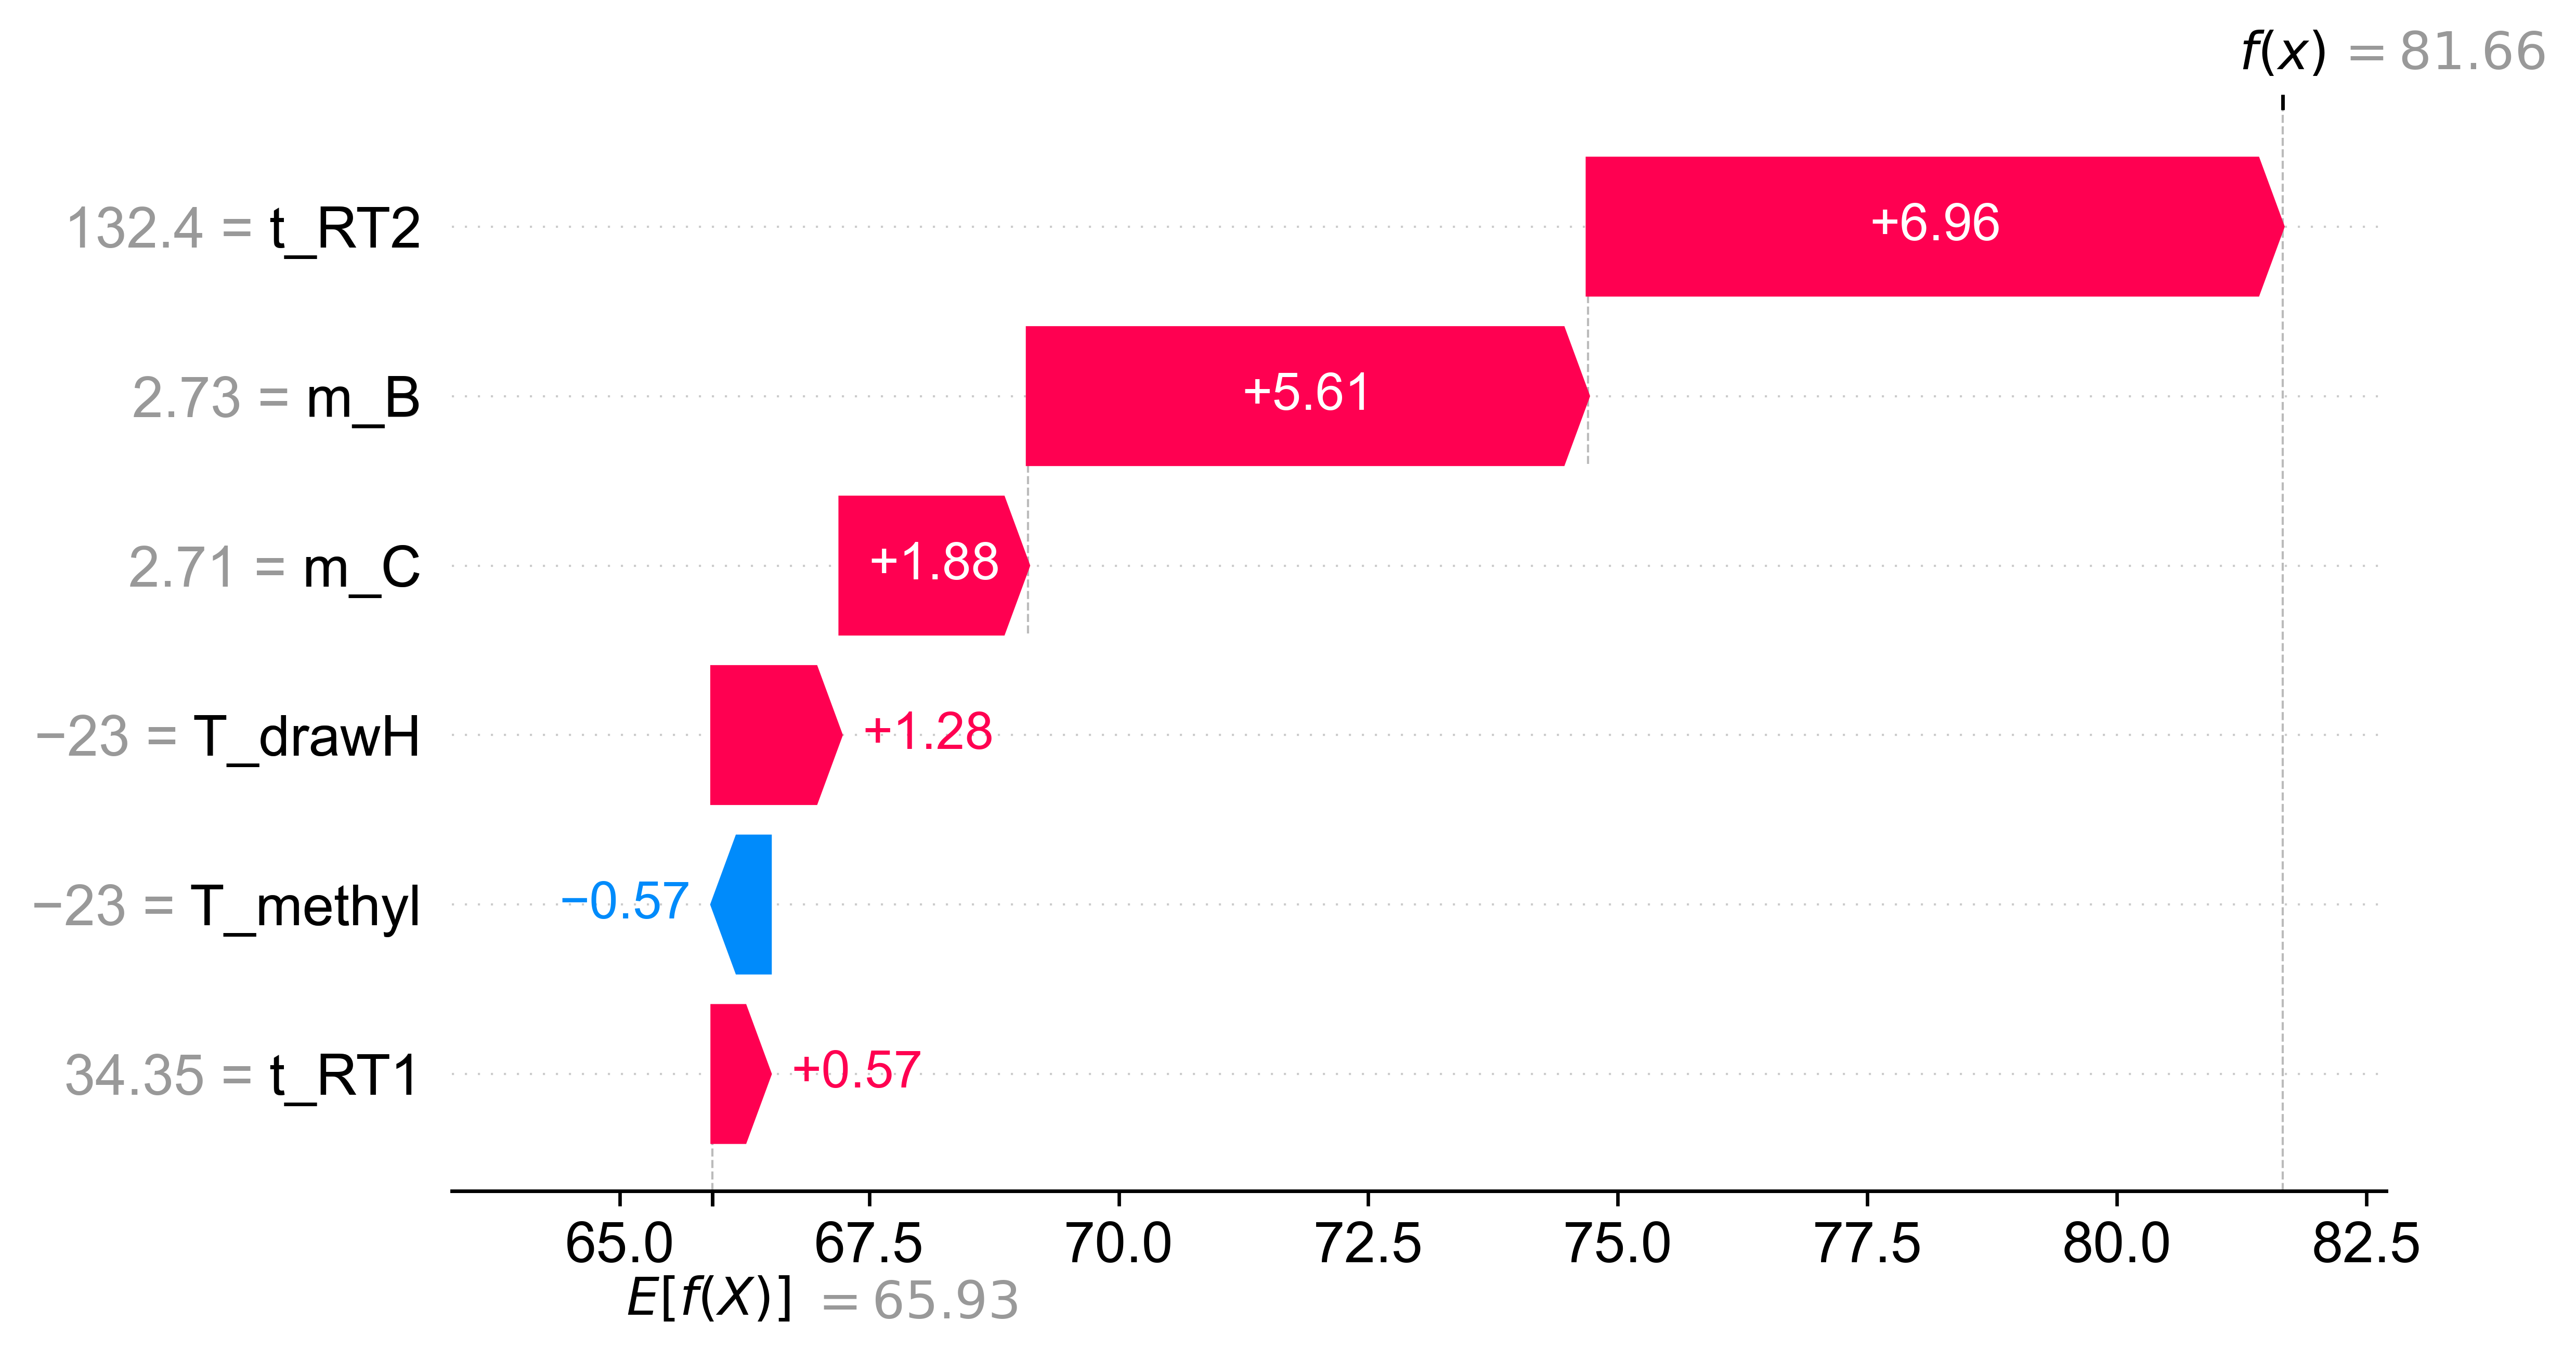

83.42


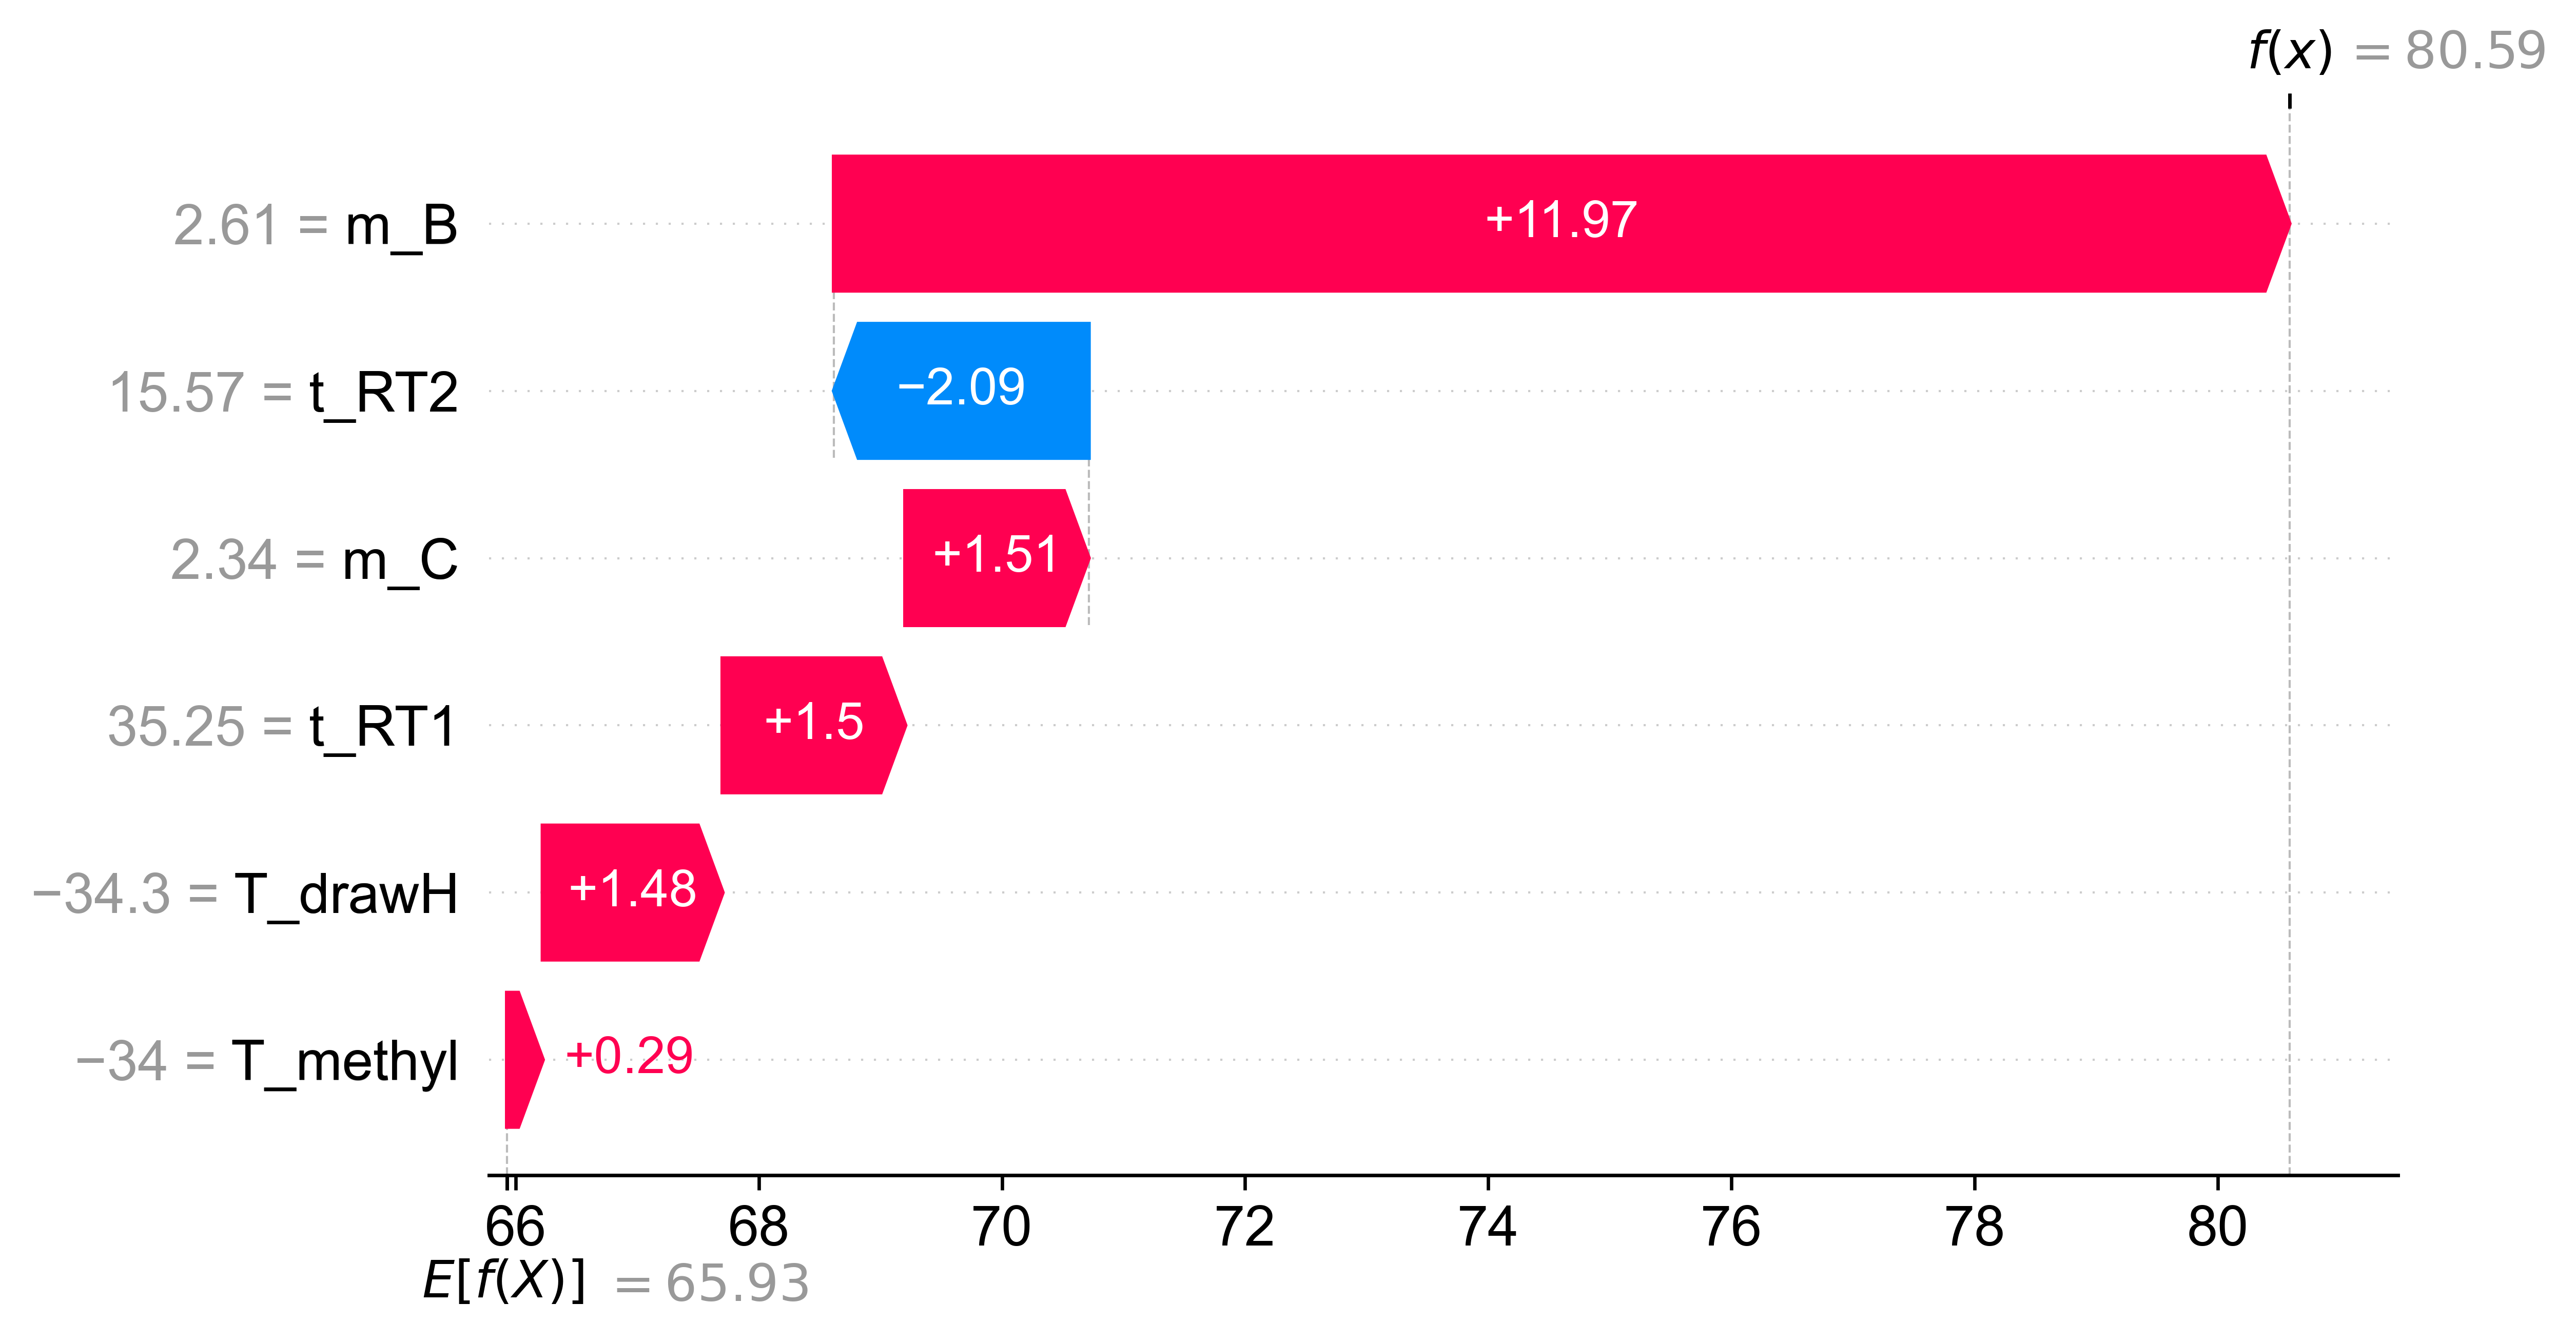

24.49


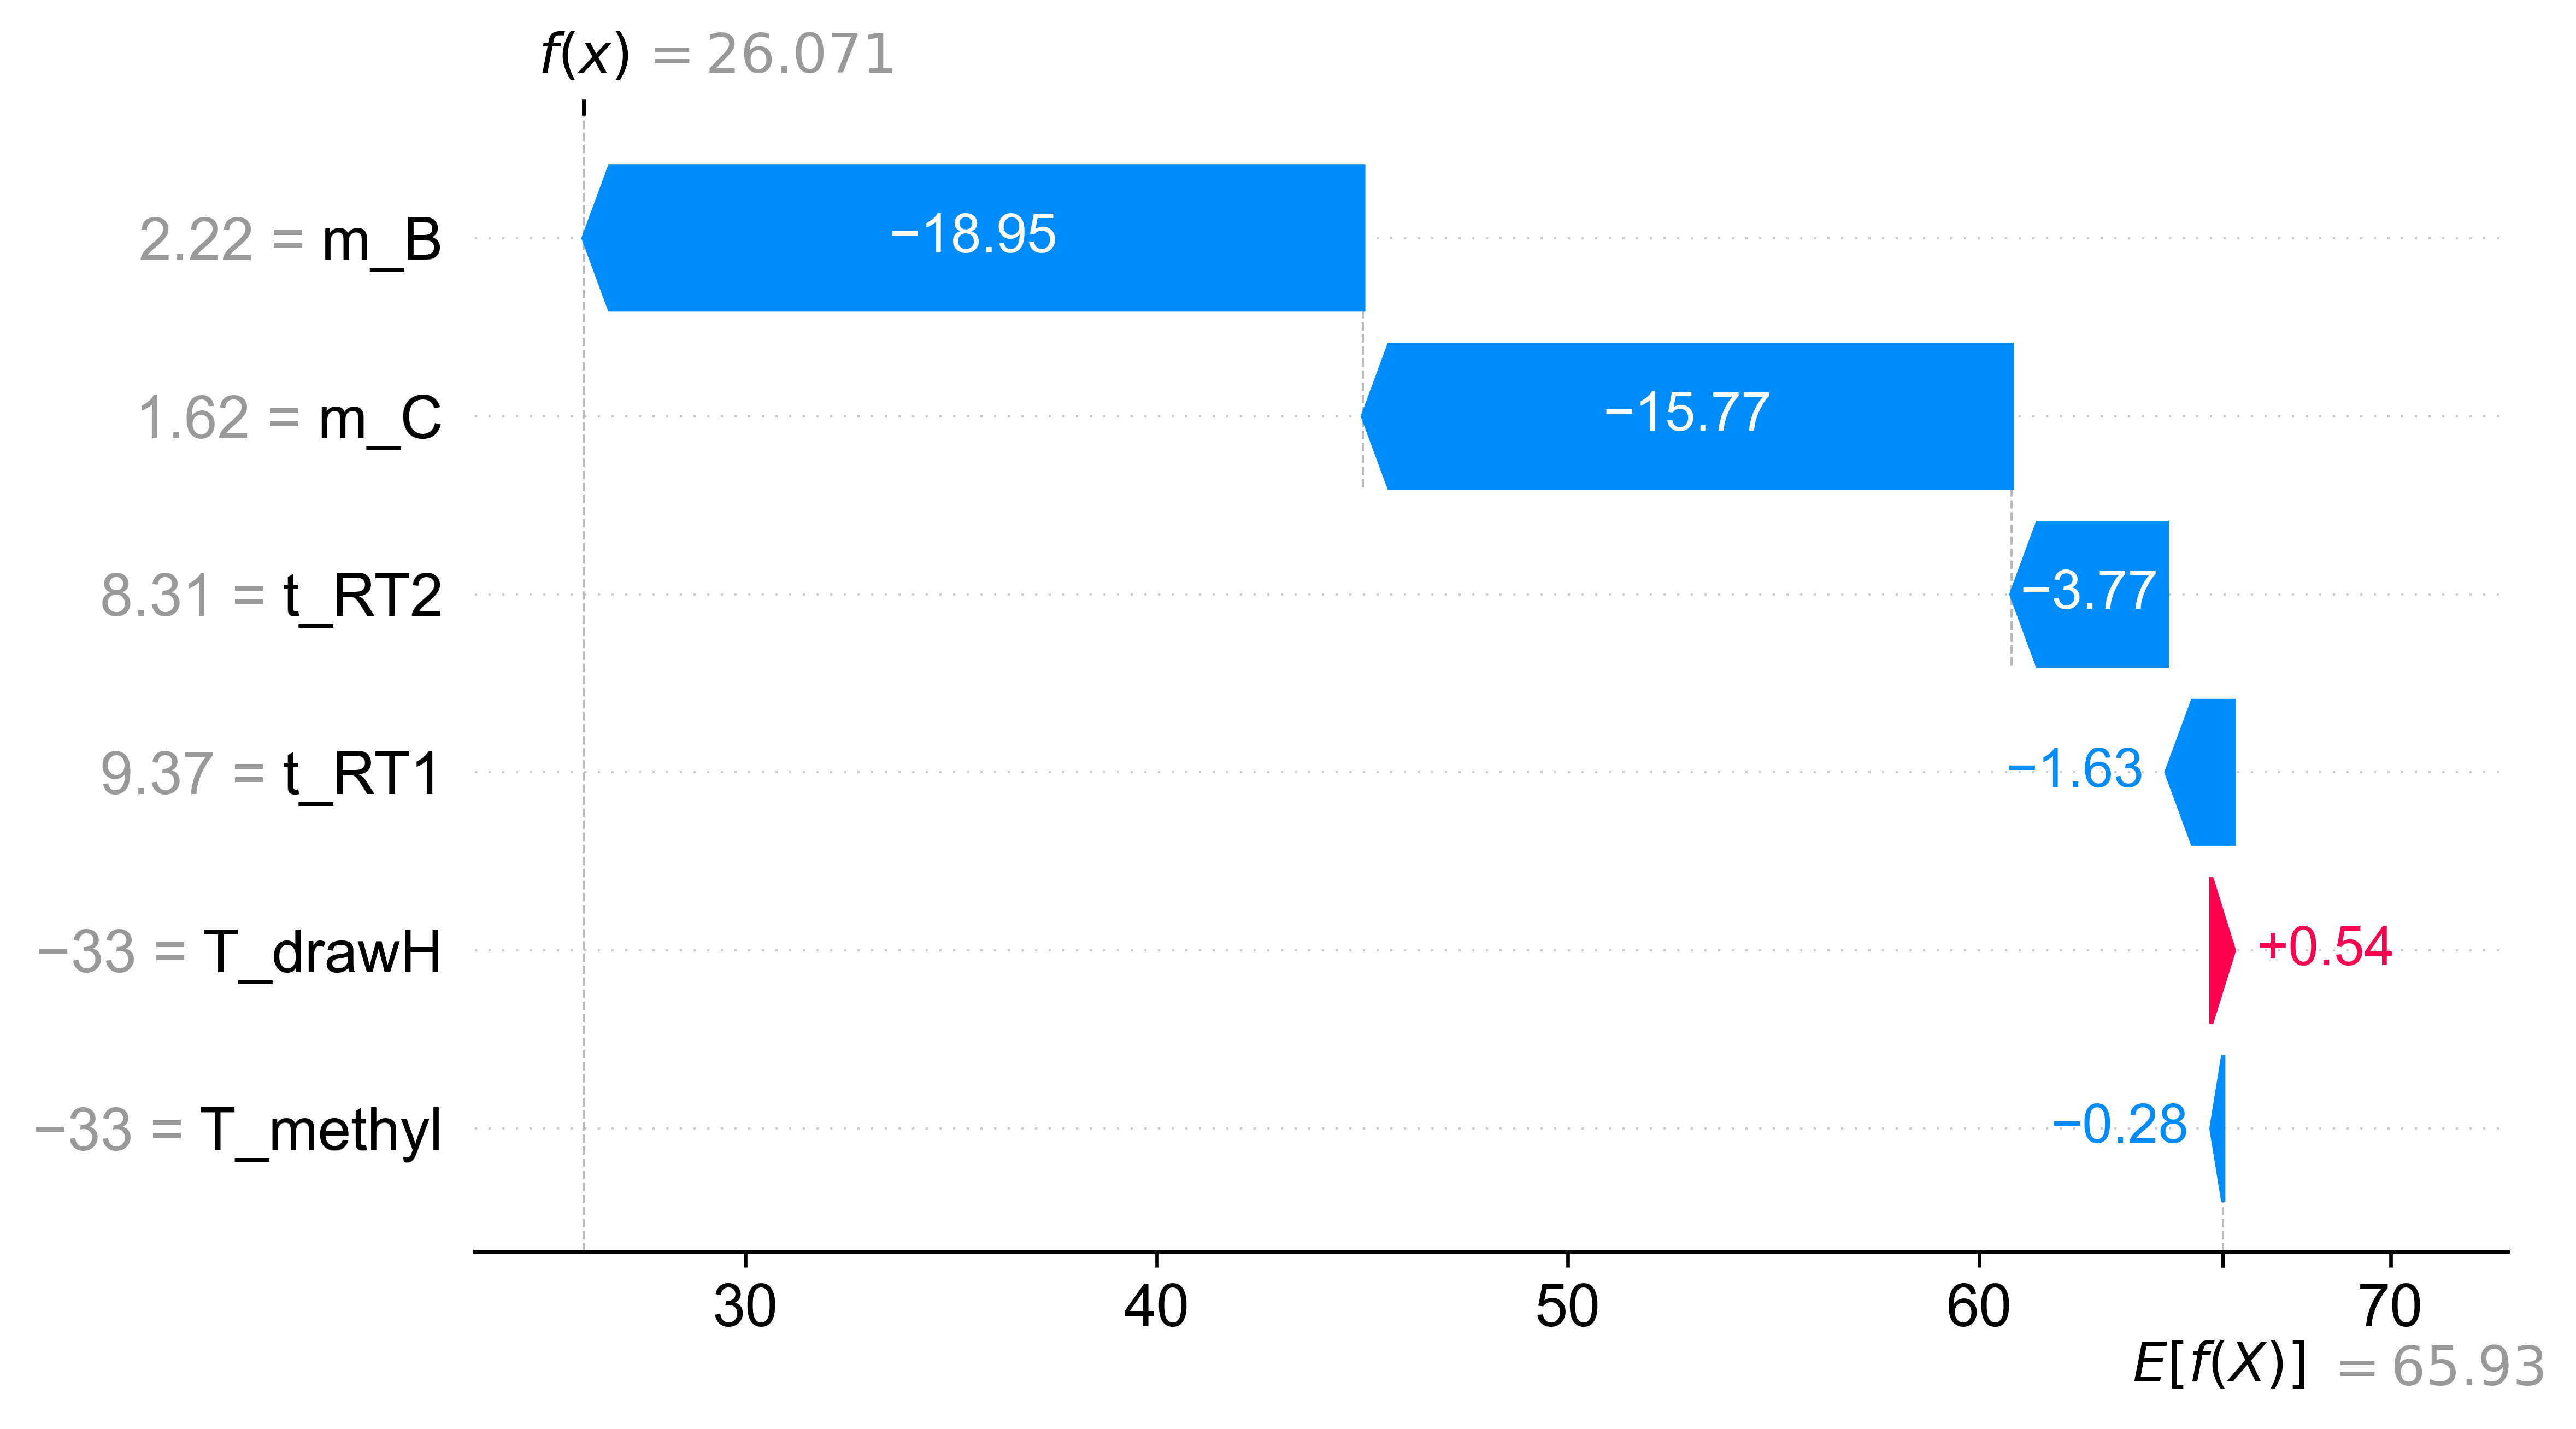

26.07


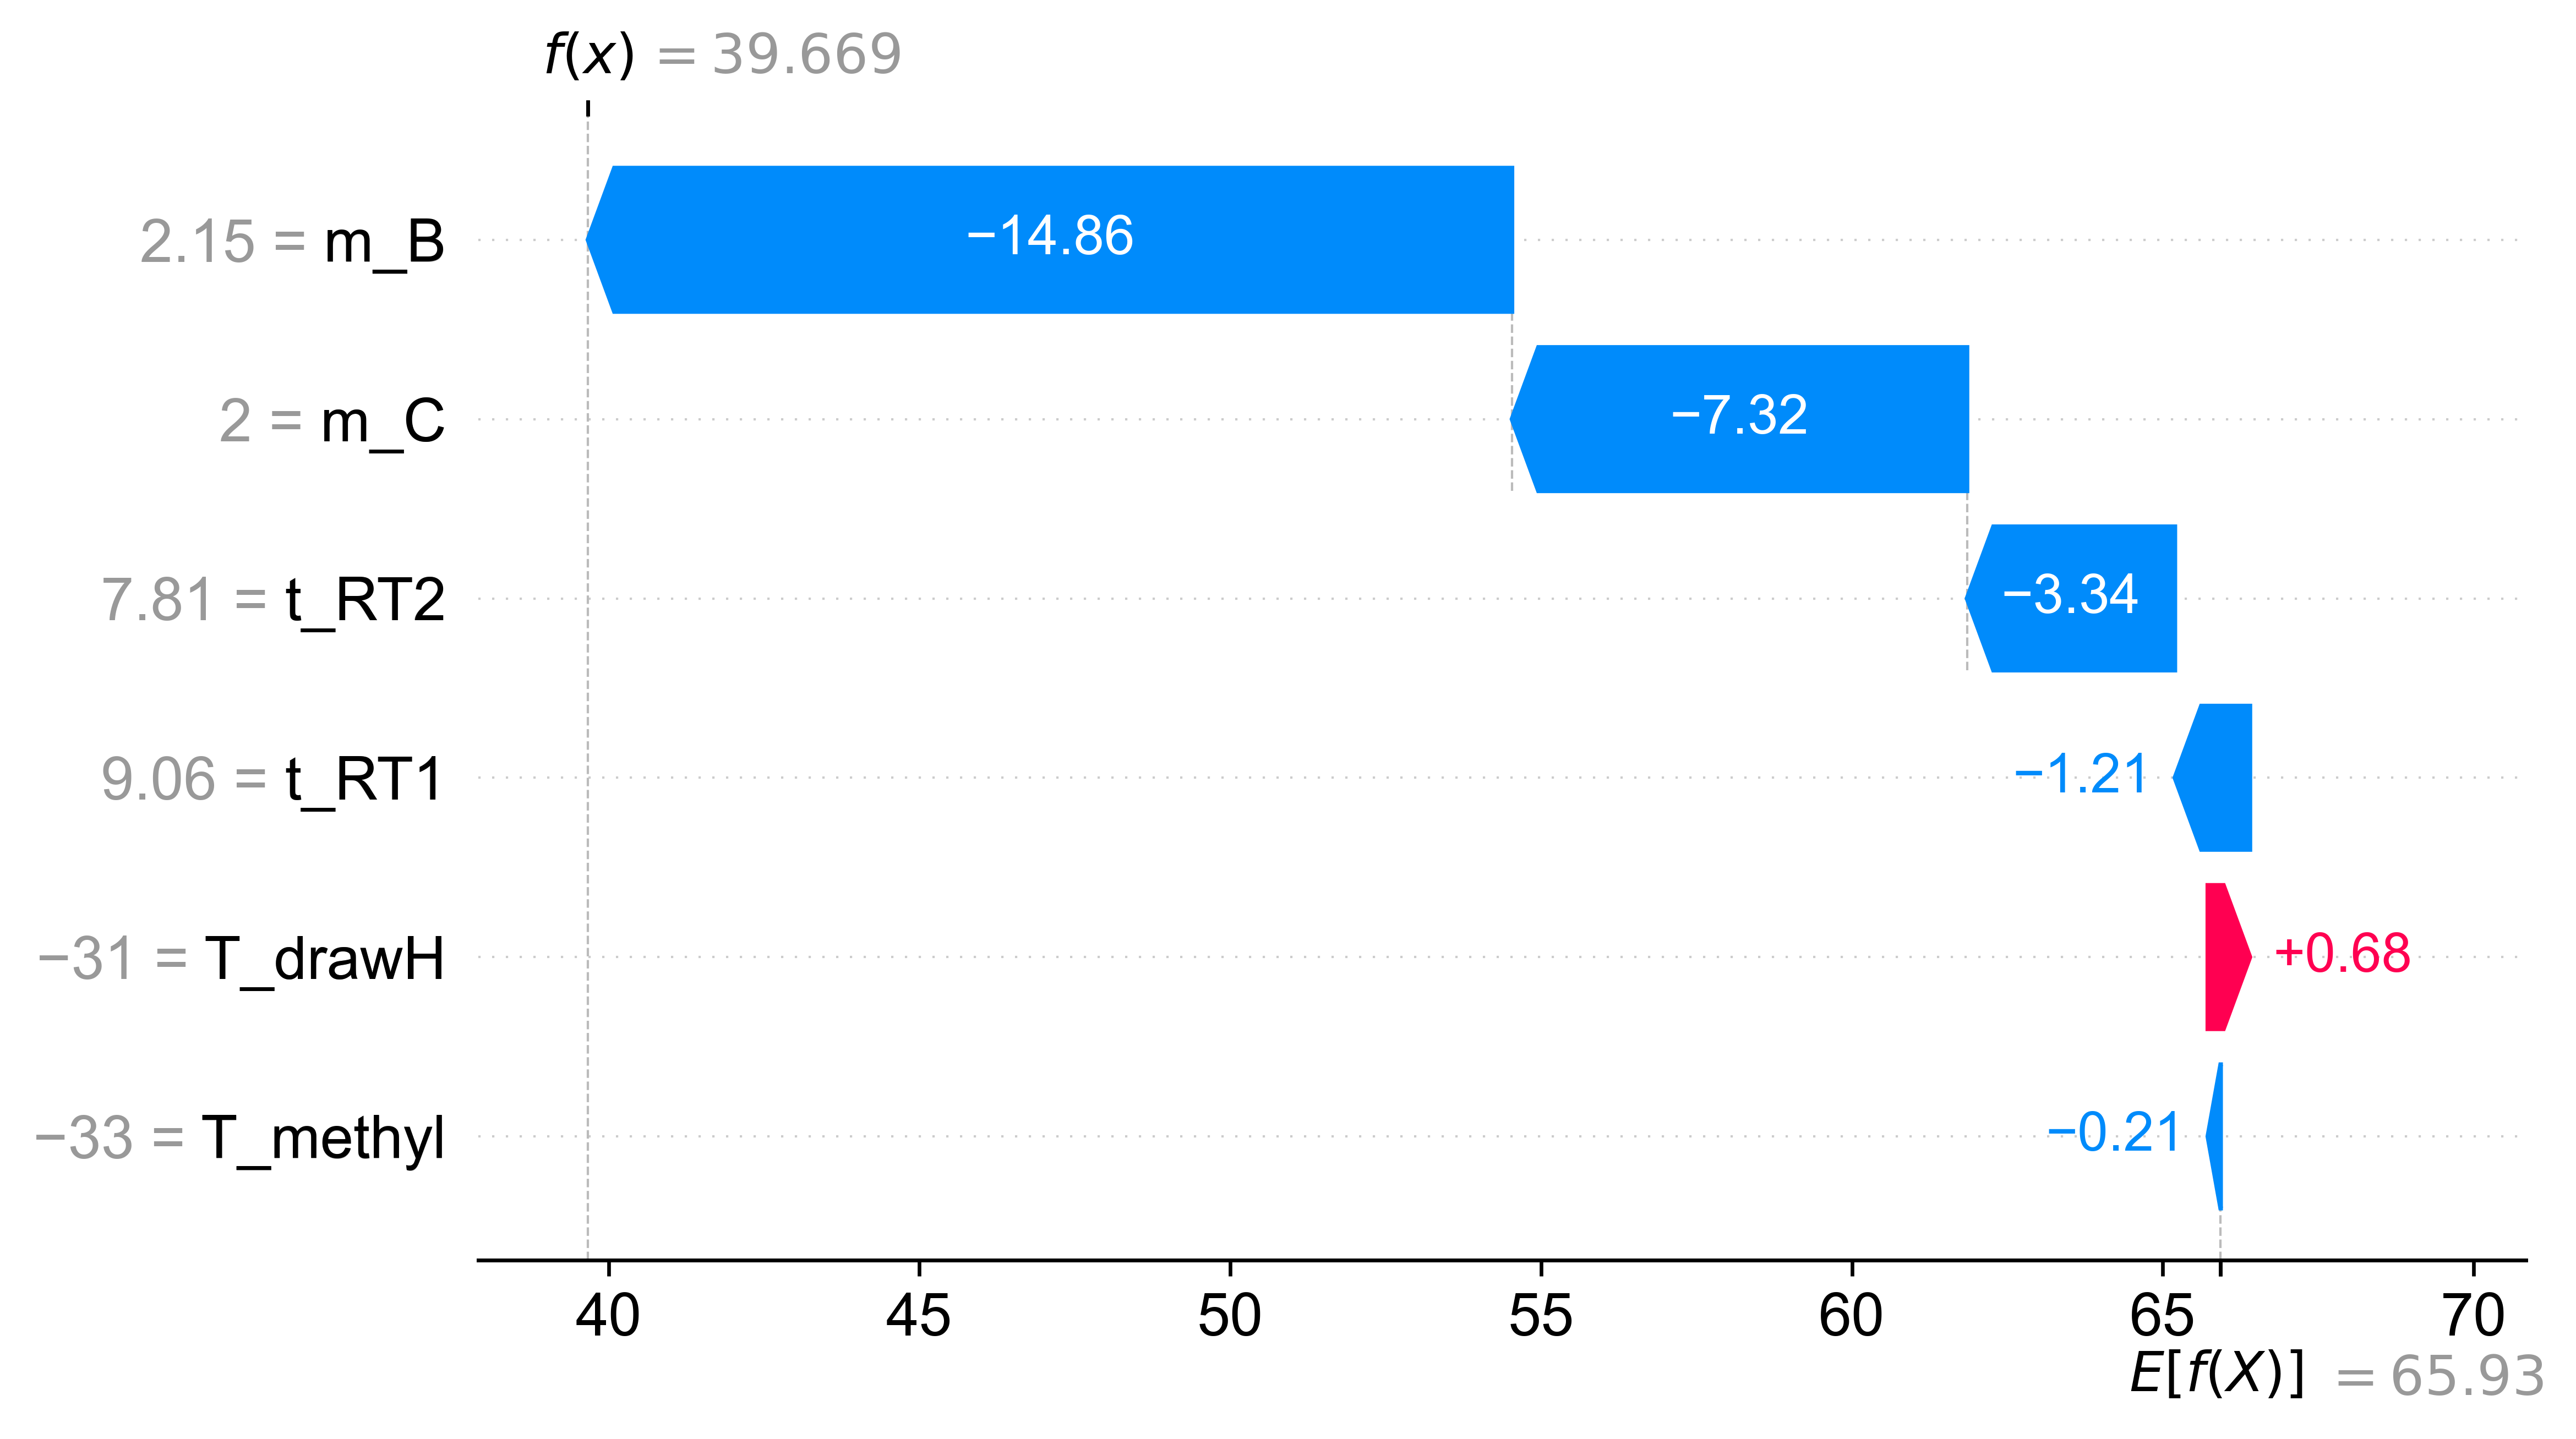

39.67


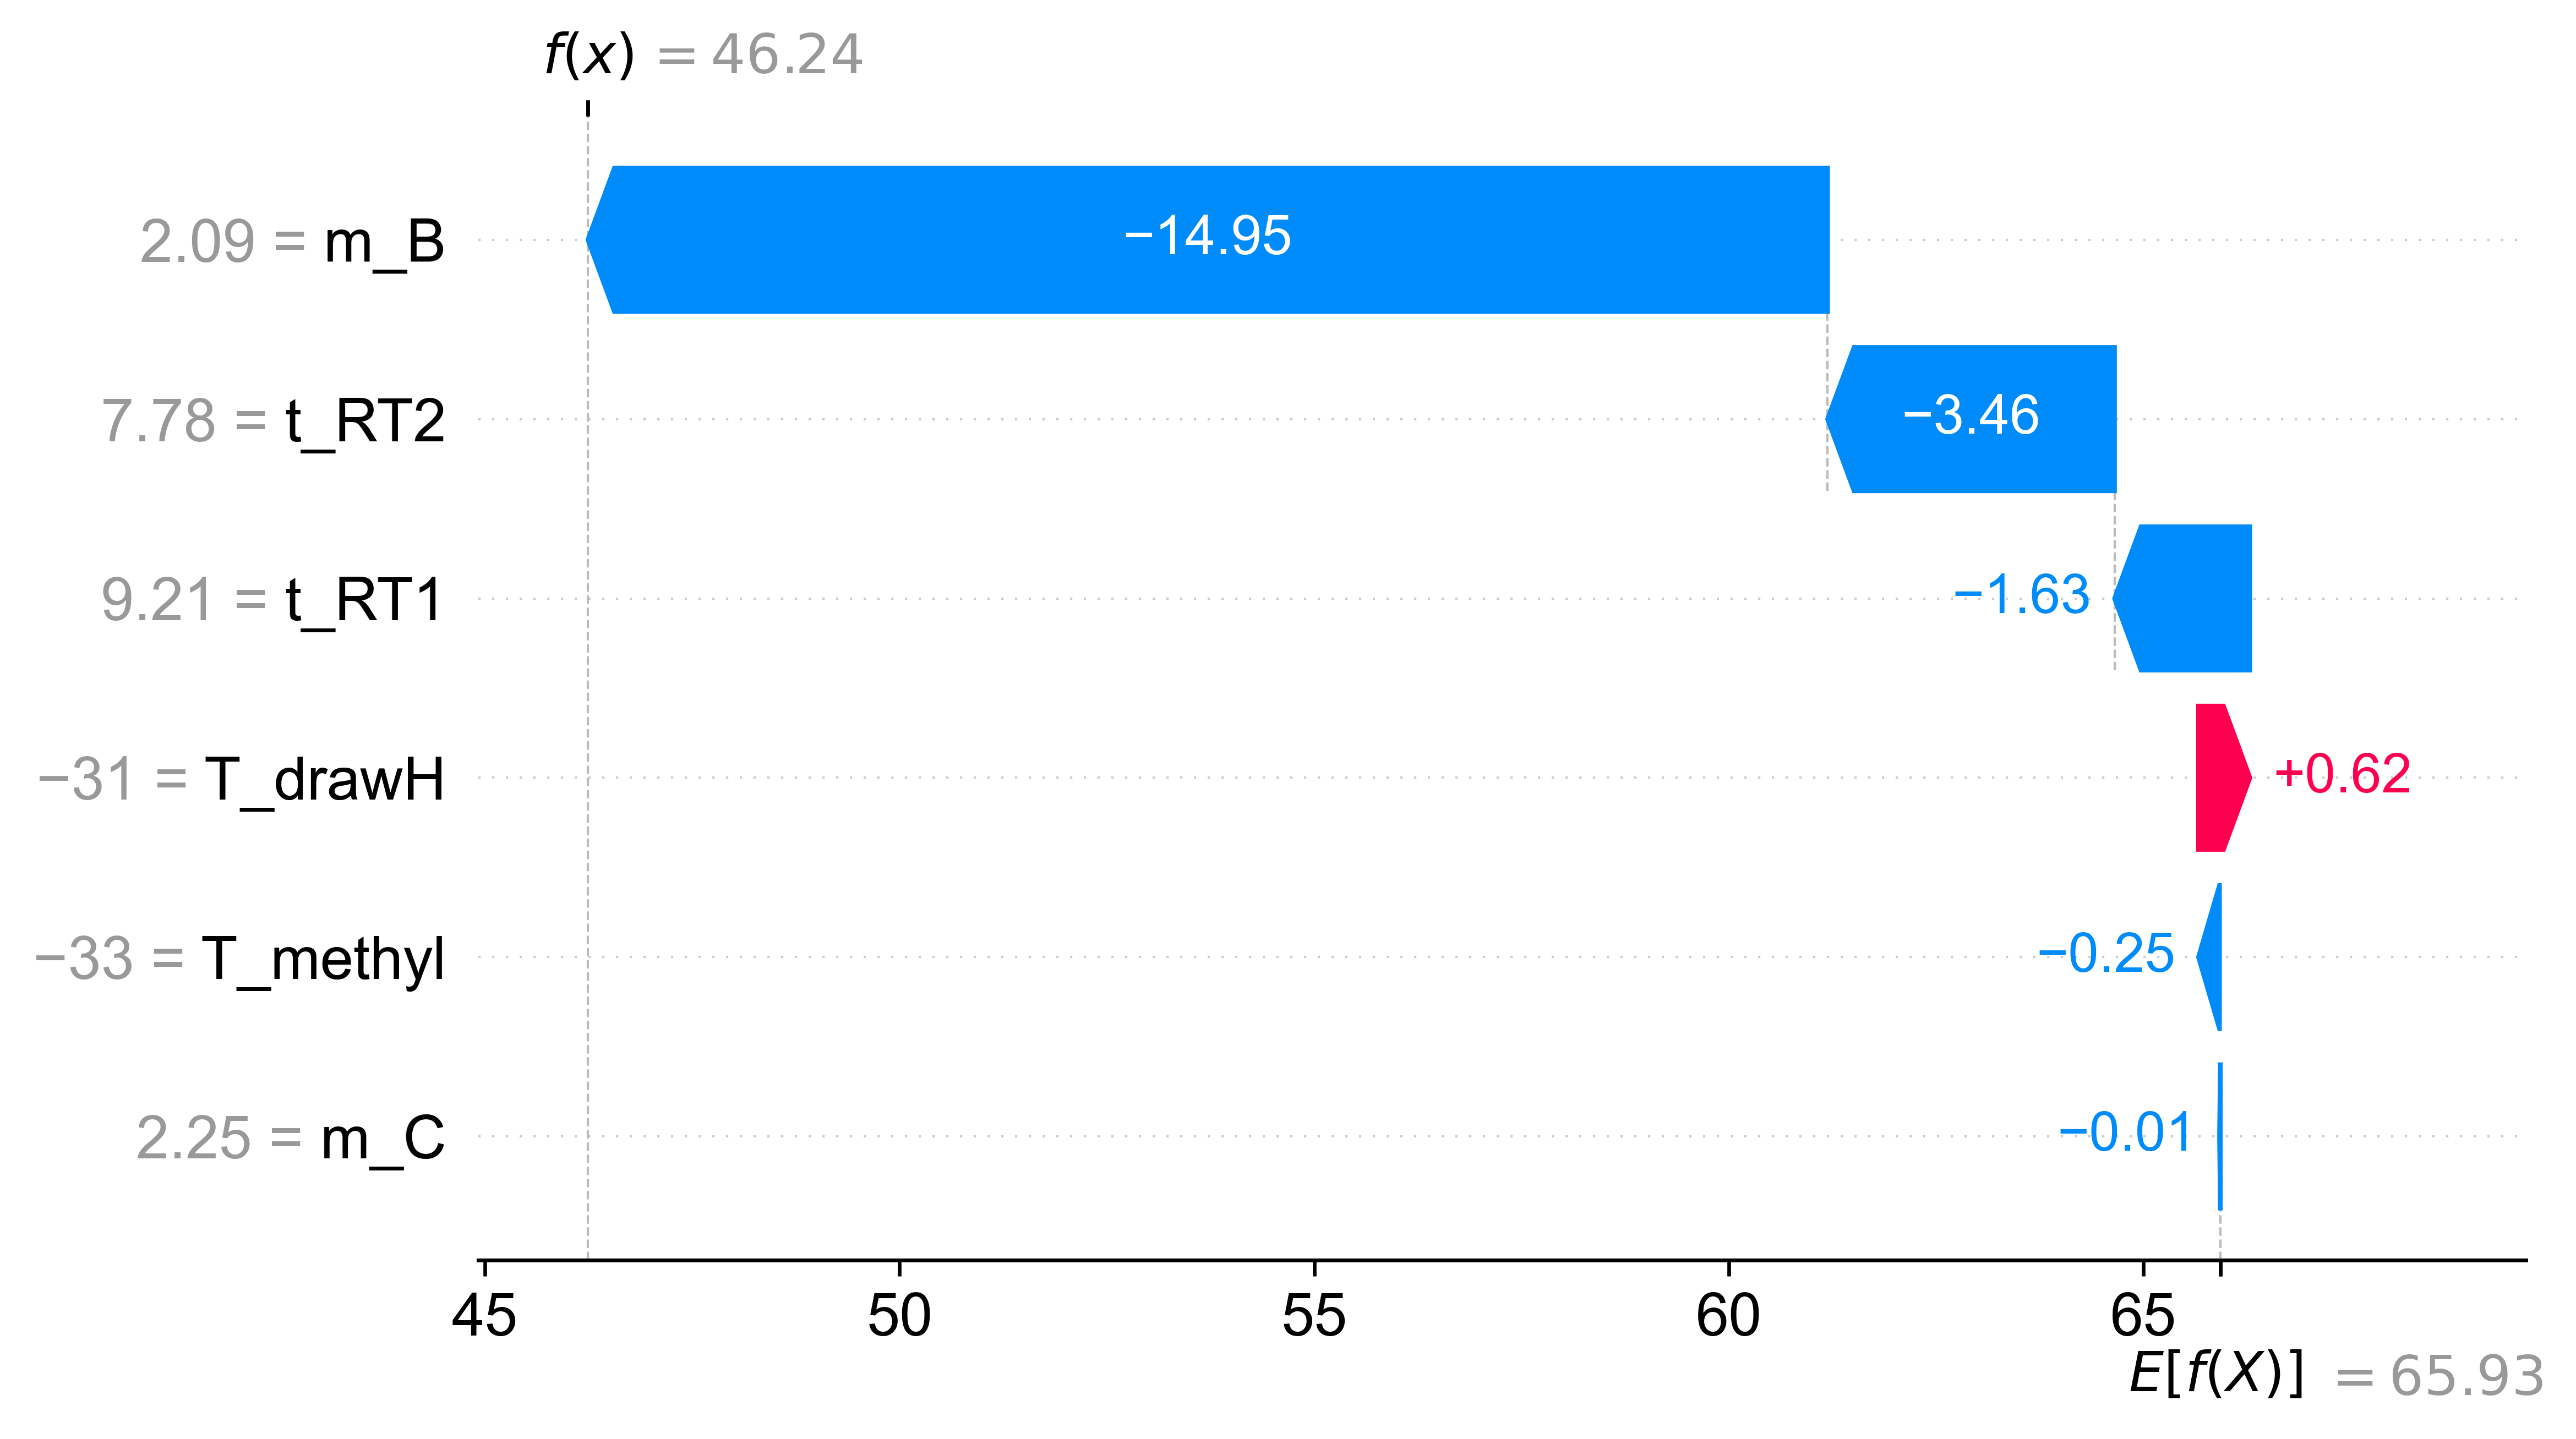

In [28]:
for i in best_idx + worst_idx:
    fig, ax = plt.subplots(dpi=600)
    print(df_yield.loc[i, "yield"])
    shap.plots.waterfall(shap_values[i])
    plt.show()

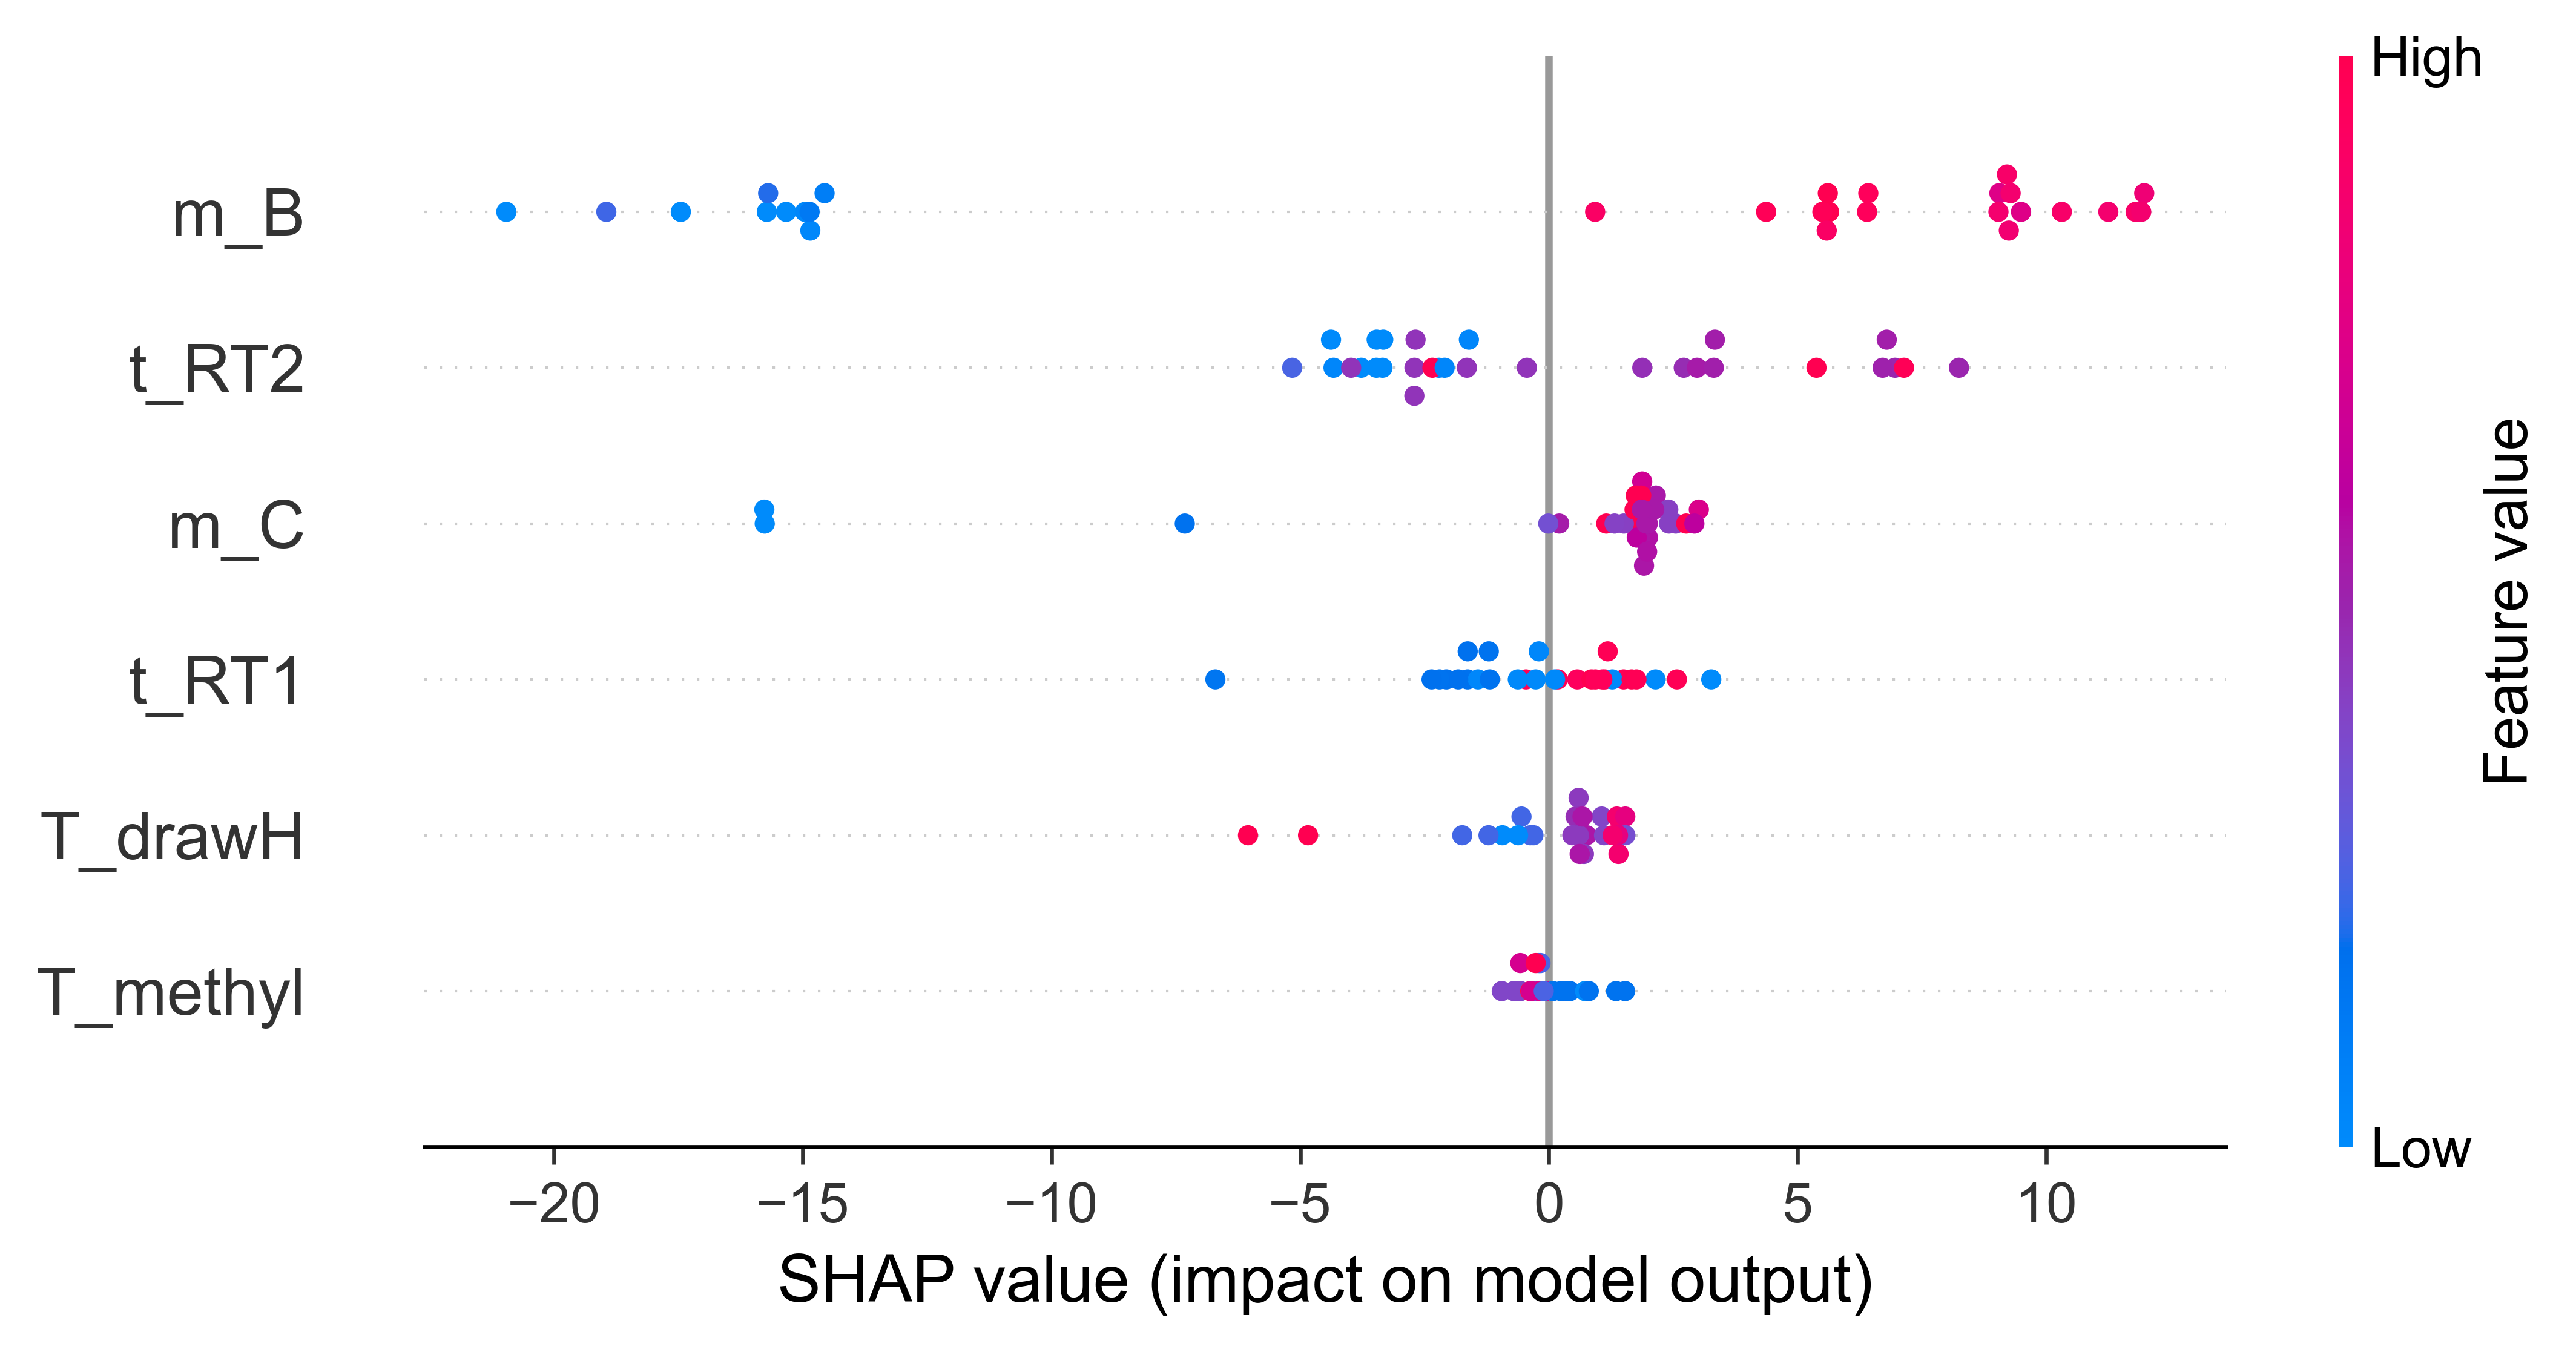

In [29]:
fig, ax = plt.subplots(dpi=600)
shap.plots.beeswarm(shap_values)
plt.show()

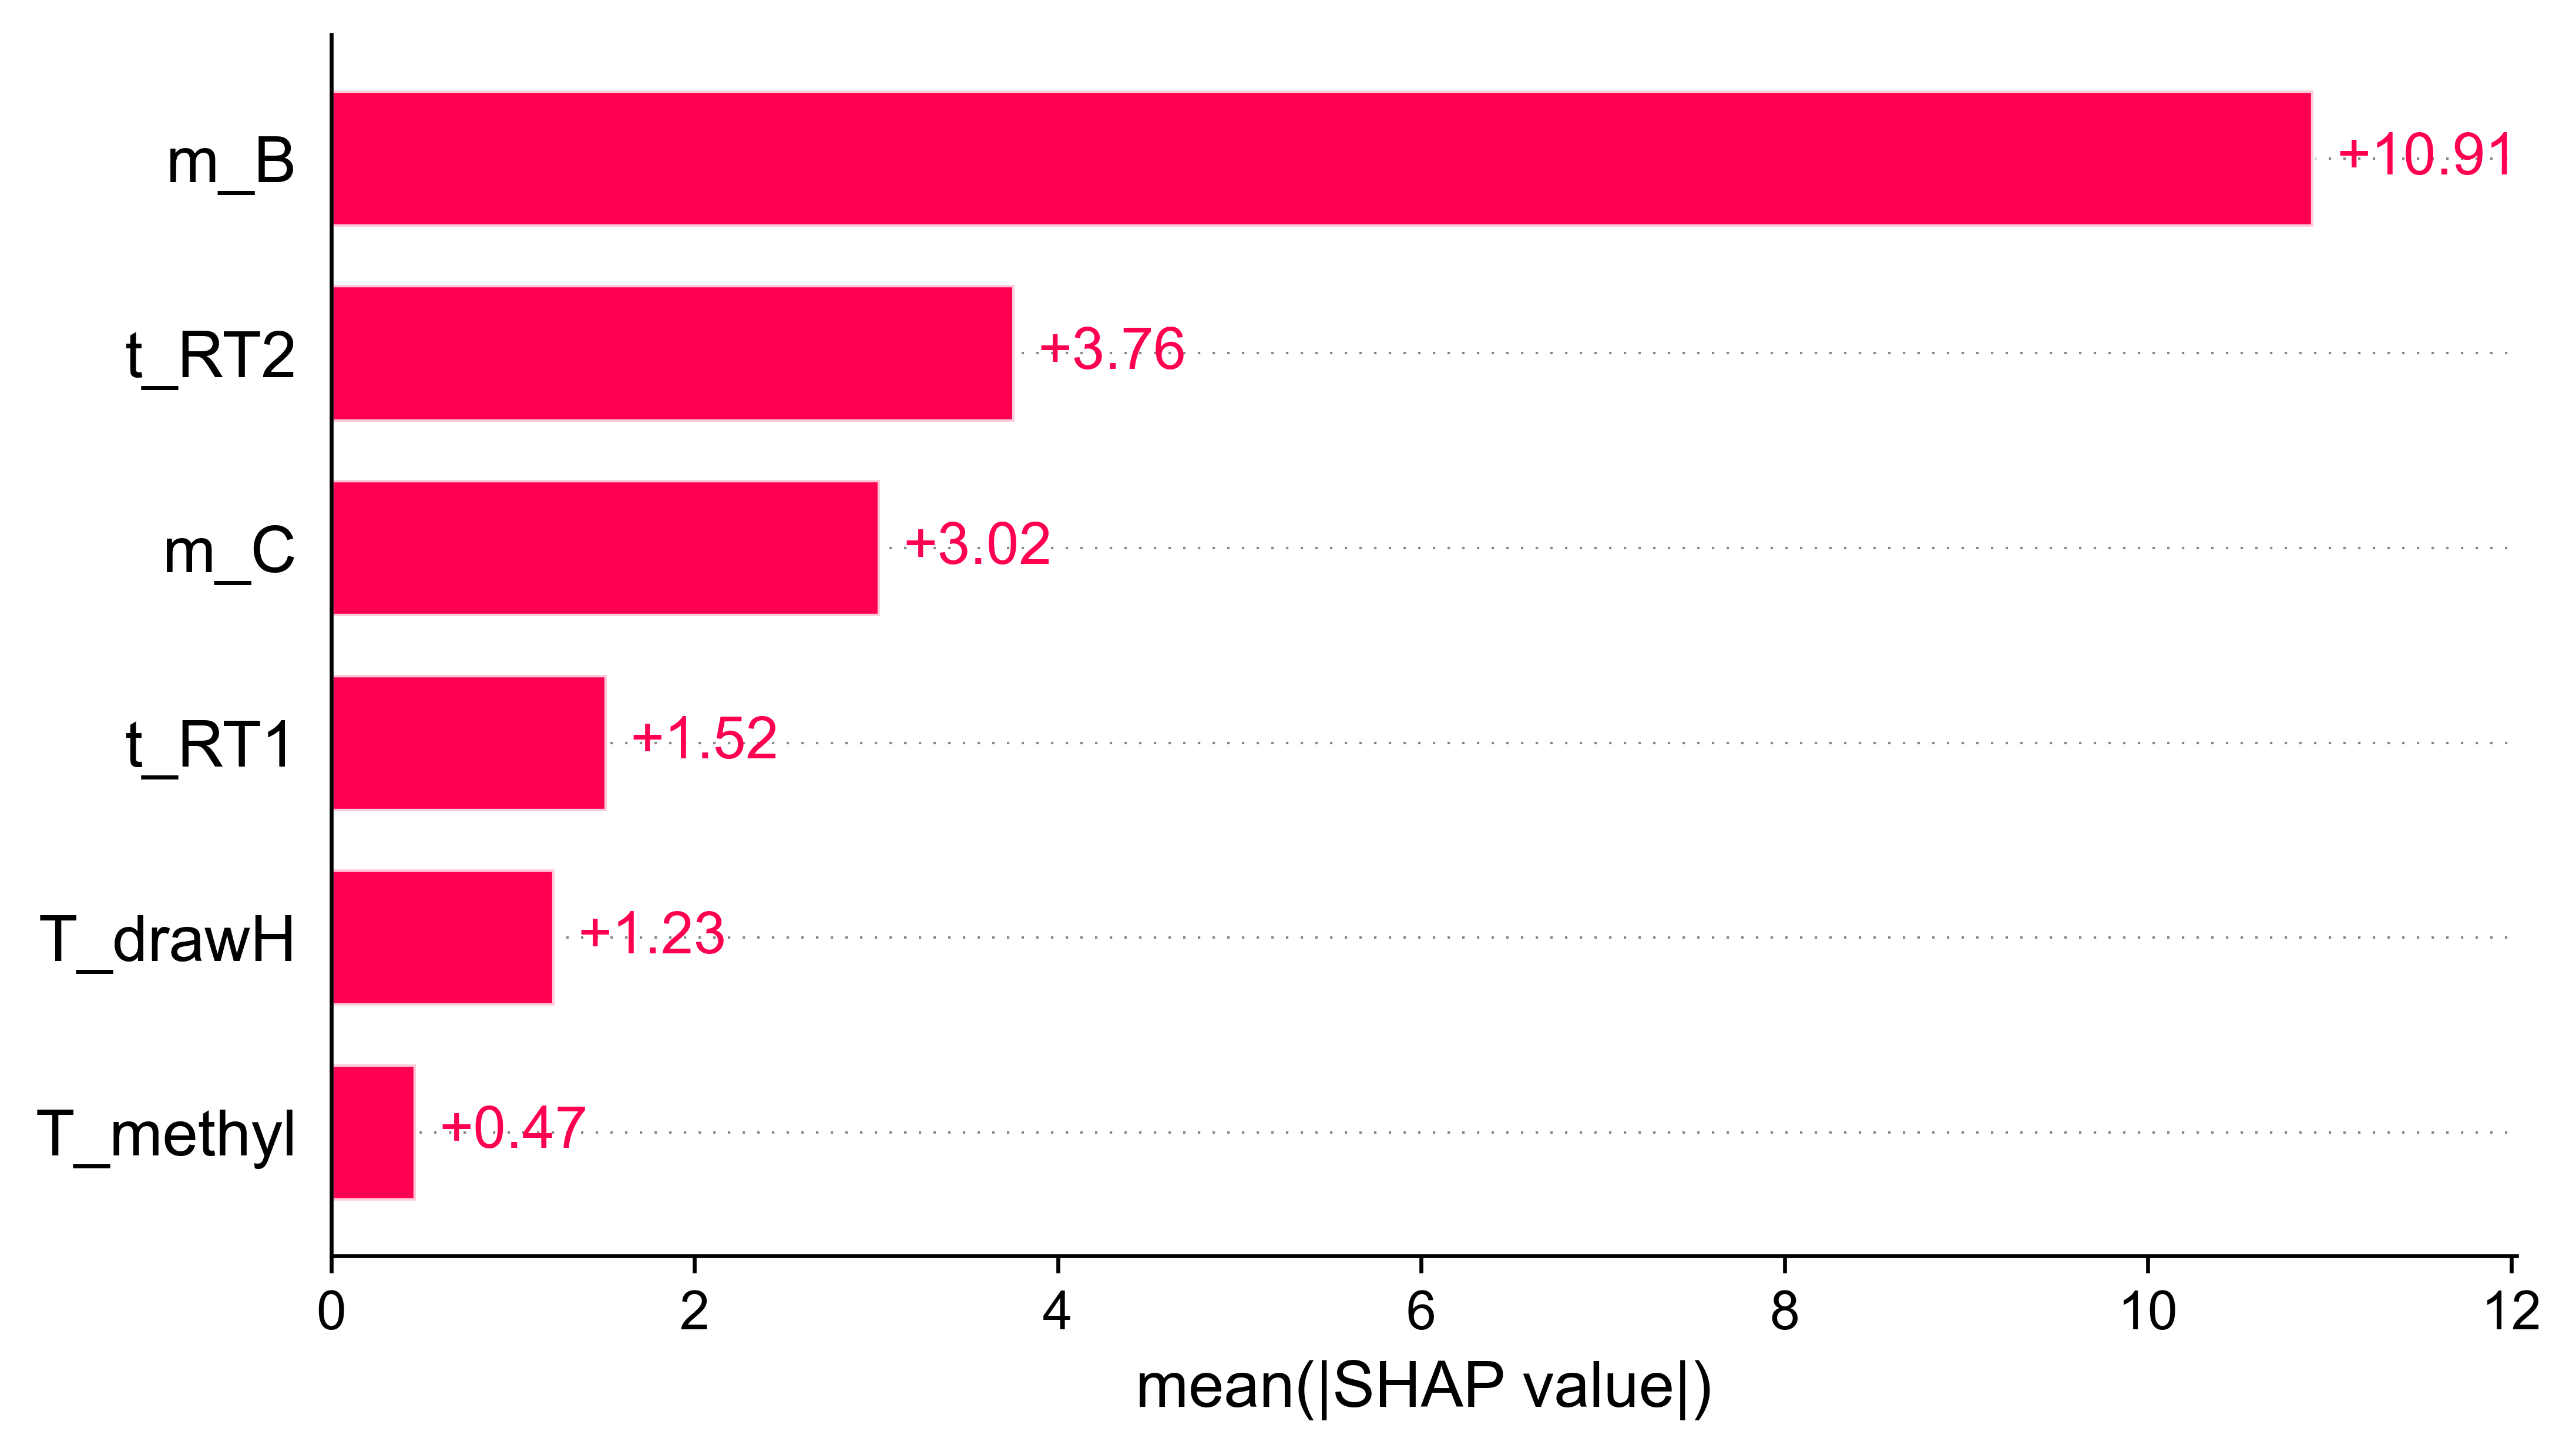

In [30]:
fig, ax = plt.subplots(dpi=600)
shap.plots.bar(shap_values)
plt.show()